# Parcels Experiment:<br><br>Expanding the polyline code to release particles at density based on local velocity normal to section.

_(Based on an experiment originally designed by Christina Schmidt.)_

_(Runs on GEOMAR Jupyter Server at https://schulung3.geomar.de/user/workshop007/lab)_

## To do

- Check/ask how OceanParcels deals with partial cells, if it does.
    - It doesn't. Does it matter?

## Technical preamble

In [1]:
%matplotlib inline

from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable
)

# from operator import attrgetter
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cmocean as co
import pandas as pd
import xarray as xr
# import dask as dask


INFO: Compiled ParcelsRandom ==> /tmp/parcels-62665/libparcels_random_a6a581ca-fc11-4050-b124-f48cec05a5c5.so


## Experiment settings (user input)

### Parameters
These can be set in papermill

In [2]:
# OSNAP multiline details
sectionPathname = '../data/external/'
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
# location of input data
path_name = '/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/'
experiment_name = 'VIKING20X.L46-KKG36107B' 
data_resolution = '1m'
w_name_extension = '_repaire_depthw_time'

# location of mask data
mask_path_name = '/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/suppl/'
mesh_mask_filename = '1_mesh_mask.nc_notime_depthw'
# location of output data
outpath_name = '../data/raw/'

year_prefix = 201  # this does from 2000 onwards

# set line segment to use
start_vertex = 4
end_vertex = 12

# experiment duration etc
runtime_in_days = 10
dt_in_minutes = -10
# repeatdt = timedelta(days=3)

# number of particles to track
create_number_particles = 200000  # many will not be ocean points
use_number_particles = 200000

min_release_depth = 0
max_release_depth = 1_000  

# max current speed for particle selection
max_current = 1.0

# set base release date and time
t_0_str = '2010-01-16T12:00:00'
t_start_str = '2016-01-16T12:00:00'

# particle positions are stored every x hours 
outputdt_in_hours = 120

# select subdomain (to decrease needed resources) comment out to use whole domain
# sd_i1, sd_i2 = 0, 2404  # western/eastern limit (indices not coordinates)
# sd_j1, sd_j2 = 1200, 2499  # southern/northern limit (indices not coordinates)
# sd_z1, sd_z2 = 0, 46

# how to initialize the random number generator
# --> is set in next cell
# RNG_seed = 123

use_dask_chunks = True

In [3]:
# Parameters
path_name = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/"
data_resolution = "5d"
w_name_extension = ""
mask_path_name = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/suppl/"
mesh_mask_filename = "1_mesh_mask.nc"
year_prefix = ""
runtime_in_days = 3650
create_number_particles = 4000000
use_number_particles = 4000000
max_release_depth = 1000
max_current = 2.0
t_0_str = "1980-01-03T12:00:00"
t_start_str = "2019-07-02T12:00:00"
use_dask_chunks = False


### Derived variables

In [4]:
# times
t_0 = datetime.fromisoformat(t_0_str)  # using monthly mean fields. Check dates.
t_start = datetime.fromisoformat(t_start_str)
# RNG seed based on release day (days since 1980-01-03)
RNG_seed = int((t_start - t_0).total_seconds() / (60*60*24))

# names of files to load 
fname_U = f'1_{experiment_name}_{data_resolution}_{year_prefix}*_grid_U.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_{year_prefix}*_grid_V.nc'
fname_T = f'1_{experiment_name}_{data_resolution}_{year_prefix}*_grid_T.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_{year_prefix}*_grid_W.nc{w_name_extension}'

sectionPath = Path(sectionPathname)

data_path = Path(path_name)

mask_path = Path(mask_path_name)

outpath = Path(outpath_name)

display(t_0)
display(t_start)

datetime.datetime(1980, 1, 3, 12, 0)

datetime.datetime(2019, 7, 2, 12, 0)

In [5]:
if dt_in_minutes > 0:
    direction = '_forwards_'
else:
    direction = '_backward_'

year_str = str(t_start.year)
month_str = str(t_start.month).zfill(2)
day_str = str(t_start.day).zfill(2)
days = str(runtime_in_days)
seed = str(RNG_seed)
npart= str(use_number_particles)



In [6]:
degree2km = 1.852*60.0


## Construct input / output paths etc.

In [7]:
mesh_mask = mask_path / mesh_mask_filename


## Load input datasets

In [8]:
def fieldset_defintions(
    list_of_filenames_U, list_of_filenames_V,
    list_of_filenames_W, list_of_filenames_T,
    mesh_mask
):
    ds_mask = xr.open_dataset(mesh_mask)
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                 'T': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_T},
                 'S': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_T},
                 'MXL': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'data': list_of_filenames_T}
                }
    
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                 'T': 'votemper',
                 'S': 'vosaline',
                 'MXL':'somxl010'
                }
        
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'T': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on t-nodes
                  'S': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on t-nodes
                  'MXL': {'lon': 'glamf', 'lat': 'gphif',
                        'time': 'time_counter'},  # needs to be on t-nodes
                 }
    
    # exclude the two grid cells at the edges of the nest as they contain 0
    # and everything south of 20N
    indices = {'lon': range(2, ds_mask.x.size-2), 'lat': range(1132, ds_mask.y.size-2)}
    
#     indices = {
#         'U': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
#         'V': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
#         'W': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)},
#         'T': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)},
#         'S': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)}
#     }    
    
    if use_dask_chunks:
        field_chunksizes = {'U': {'lon':('x', 1024), 'lat':('y',128), 'depth': ('depthw', 64),
                            'time': ('time_counter',3)},  # needs to be on f-nodes
                      'V': {'lon':('x', 1024), 'lat':('y',128), 'depth': ('depthw', 64),
                            'time': ('time_counter',3)},  # needs to be on f-nodes
                      'W': {'lon':('x', 1024), 'lat':('y',128), 'depth': ('depthw', 64),
                            'time': ('time_counter',3)},  # needs to be on f-nodes
                      'T': {'lon':('x', 1024), 'lat':('y',128), 'depth': ('depthw', 64),
                            'time': ('time_counter',3)},  # needs to be on t-nodes
                      'S': {'lon':('x', 1024), 'lat':('y',128), 'depth': ('depthw', 64),
                            'time': ('time_counter',3)},  # needs to be on t-nodes
                      'MXL': {'lon':('x', 1024), 'lat':('y',128),
                            'time': ('time_counter',3)},  # needs to be on t-nodes
                     }
    else:
        field_chunksizes = None

    return FieldSet.from_nemo(
        filenames, variables, dimensions, 
        indices=indices,
        chunksize=field_chunksizes,  # = None for no chunking
        mesh='spherical',
        tracer_interp_method='cgrid_tracer'
#         ,time_periodic=time_loop_period
#         ,allow_time_extrapolation=True
    )

In [9]:
def create_fieldset(
    data_path=data_path, experiment_name=experiment_name,
    fname_U=fname_U, fname_V=fname_V, fname_W=fname_W, fname_T=fname_T,
    mesh_mask = mesh_mask
):
    
    files_U = list(sorted((data_path).glob(fname_U)))
    files_V = list(sorted((data_path).glob(fname_V)))
    files_W = list(sorted((data_path).glob(fname_W)))
    files_T = list(sorted((data_path).glob(fname_T)))
    
    print(files_U)
    
    fieldset = fieldset_defintions(
        files_U, files_V,
        files_W, files_T, mesh_mask)

    return fieldset

In [10]:
fieldset = create_fieldset()

[PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_5d_19800101_19801231_grid_U.nc'), PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_5d_19810101_19811231_grid_U.nc'), PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_5d_19820101_19821231_grid_U.nc'), PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_5d_19830101_19831231_grid_U.nc'), PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_5d_19840101_19841231_grid_U.nc'), PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_5d_19850101_19851231_grid_U.nc'), PosixPath('/gxfs_work1/geomar/smomw355/model_data/ocean-o

## Create Virtual Particles

#### add a couple of simple plotting routines

In [11]:
def plot_section_sdist():
    plt.figure(figsize=(10,5))

    u = np.array([p.uvel for p in pset]) * degree2km * 1000.0 * np.cos(np.radians(pset.lat))
    v = np.array([p.vvel for p in pset]) * degree2km * 1000.0
    section_index = np.searchsorted(lonlat.lon,pset.lon)-1
    u_normal = v * lonlatdiff.costheta[section_index].data - u * lonlatdiff.sintheta[section_index].data
    y = (pset.lat - lonlat.lat[section_index]) * degree2km
    x = (pset.lon - lonlat.lon[section_index]) * degree2km*np.cos(np.radians(lonlat2mean.lat[section_index+1].data))
    dist = np.sqrt(x**2 + y**2) + lonlatdiff.length_west[section_index].data
    
    
    plt.scatter(
        dist,
        [p.depth for p in pset],
        1,
        u_normal,
        cmap=co.cm.balance,vmin=-0.3,vmax=0.3
    )
    plt.ylim(1200,0)
    plt.colorbar(label = r'normal velocity [$\mathrm{m\ s}^{-1}$]')
    plt.xlabel('distance [km]')
    plt.ylabel('depth [m]')
    return


In [12]:
def plot_section_lon():
    plt.figure(figsize=(10,5))

    u = np.array([p.uvel for p in pset]) * degree2km * 1000.0 * np.cos(np.radians(pset.lat))
    v = np.array([p.vvel for p in pset]) * degree2km * 1000.0
    section_index = np.searchsorted(lonlat.lon,pset.lon)-1
    u_normal = v * lonlatdiff.costheta[section_index].data - u * lonlatdiff.sintheta[section_index].data
    
    plt.scatter(
        [p.lon for p in pset],
        [p.depth for p in pset],
        1,
        u_normal,
        cmap=co.cm.balance,vmin=-0.3,vmax=0.3
    )
    plt.ylim(1200,0)
    plt.colorbar(label = r'normal velocity [$\mathrm{m\ s}^{-1}$]');
    plt.xlabel('longitude [$\degree$E]')
    plt.ylabel('depth [m]')
    return


In [13]:
class SampleParticle(JITParticle):
    """Add variables to the standard particle class.
    
    Particles will sample temperature and track the age of the particle.
    Particles also have a flag `alive` that is 1 if the particle is alive and 0 otherwise.
    Furthermore, we have a `speed_param` that scales the velocity with which particles can
    swim towards the surface.

    Note that we don't initialize temp from the actual data.
    This speeds up particle creation, but might render initial data point less useful.
    """
    mxl = Variable('mxl', dtype=np.float32, initial=-100)
    temp = Variable('temp', dtype=np.float32, initial=-100)
    salt = Variable('salt', dtype=np.float32, initial=-100)
    uvel = Variable('uvel', dtype=np.float32, initial=0)
    vvel = Variable('vvel', dtype=np.float32, initial=0)
#    wvel = Variable('wvel', dtype=np.float32, initial=0)
#     alive = Variable('alive', dtype=np.int32, initial=1)
#     speed_param = Variable('speed_param', dtype=np.float32, initial=1)
#     age = Variable('age', dtype=np.int32, initial=0, to_write=True)

## Create a set of particles with random initial positions

We seed the RNG to be reproducible (and to be able to quickly create a second equivalent experiment with differently chosen compatible initial positions), and create arrays of random starting times, lats, lons, depths, and speed parameters (see kernel definitions below for details).

Initially create points on 'rectangle'. Land points are removed later in a OceanParcels 'run' with runtime and timedelta zero.

### First set up the piecewise section

In [14]:
lonlat = xr.Dataset(pd.read_csv(sectionPath / sectionFilename,delim_whitespace=True))

3594.572878394652


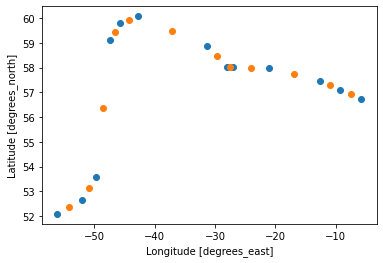

In [15]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlatdiff = lonlat.diff('dim_0')
lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlat.plot.scatter(x='lon',y='lat')
lonlat2mean.plot.scatter(x='lon',y='lat')

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'length_west':lonlatdiff.length.sum() - np.cumsum(lonlatdiff.length[::-1])[::-1]})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data
print(total_length)

In [16]:
lonlatdiff.length.shape[0]

12

### Seed particles uniform random along OSNAP section

In [17]:
np.random.seed(RNG_seed)

# define time of release for each particle relative to t0
# can start each particle at a different time if required
# here all start at time t_start.
times = []
lons = []
lats = []
depths = []

# for subsect in range(lonlatdiff.length.shape[0]):
for subsect in range(start_vertex,end_vertex):
    
    number_particles = int(create_number_particles*lonlatdiff.length[subsect]/total_length)
    time = np.zeros(number_particles)
    time += (t_start - t_0).total_seconds()

    # start along a line from west to east

    west_lat = lonlat.lat[subsect].data
    west_lon = lonlat.lon[subsect].data
    east_lat = lonlat.lat[subsect+1].data
    east_lon = lonlat.lon[subsect+1].data
    
    lon = np.random.uniform(
        low=west_lon, high = east_lon,
        size=time.shape
    )
    lat = west_lat + ((lon - west_lon) * (east_lat - west_lat)/ (east_lon - west_lon))

    # at depths from surface to max_release_depth

    depth = np.random.uniform(
        low=min_release_depth, high=max_release_depth,
        size=time.shape
    )
    times.append(time)
    lons.append(lon)
    lats.append(lat)
    depths.append(depth)

    
    
time = np.concatenate(times)
lon = np.concatenate(lons)
lat = np.concatenate(lats)
depth = np.concatenate(depths)


###  Build particle set

In [18]:
%%time

pset = ParticleSet(
    fieldset=fieldset,
    pclass=SampleParticle,
    lat=lat,
    lon=lon,
#     speed_param=speed_param,
    depth=depth,
    time=time
#    repeatdt = repeatdt
)


CPU times: user 753 ms, sys: 173 ms, total: 926 ms
Wall time: 930 ms


In [19]:
print(f"Created {len(pset)} particles.")
# display(pset[:5])
# display(pset[-5:])

Created 2643886 particles.


## Compose custom kernel

We'll create three additional kernels:
- One Kernel adds velocity sampling
- One Kernel adds temperature sampling
- One kernel adds salinity sampling

Then, we combine the builtin `AdvectionRK4_3D` kernel with these additional kernels.

In [20]:
def velocity_sampling(particle, fieldset, time):
    '''Sample velocity.'''
    
    (particle.uvel,particle.vvel) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    

In [21]:
def temperature_sampling(particle, fieldset, time):
    '''Sample temperature.'''
    
    particle.temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]

In [22]:
def salinity_sampling(particle, fieldset, time):
    '''Sample salinity.'''
    
    particle.salt = fieldset.S[time, particle.depth, particle.lat, particle.lon]

In [23]:
def mxl_sampling(particle, fieldset, time):
    '''Sample mixed layer depth.'''
    
    particle.mxl = fieldset.MXL[time, particle.depth, particle.lat, particle.lon]

In [24]:
custom_kernel = (
    pset.Kernel(AdvectionRK4_3D)
#     + pset.Kernel(temperature_sensitivity)
     + pset.Kernel(temperature_sampling)
     + pset.Kernel(salinity_sampling)
     + pset.Kernel(velocity_sampling)
     + pset.Kernel(mxl_sampling)
)

## Be able to handle errors during integration

We have restricted our domain so in principle, particles could reach undefined positions.
In that case, we want to just delete the particle (without forgetting its history).

In [25]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()


recovery_cases = {
    ErrorCode.ErrorOutOfBounds: DeleteParticle,
    ErrorCode.Error: DeleteParticle,
    ErrorCode.ErrorInterpolation: DeleteParticle
}

## Run with runtime=0 to initialise fields

In [26]:
%%time

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
pset.execute(
    custom_kernel,
     runtime=0,    
#      dt=timedelta(minutes=0),      
#      output_file=outputfile,
     recovery=recovery_cases
)

INFO: Compiled SampleParticleAdvectionRK4_3Dtemperature_samplingsalinity_samplingvelocity_samplingmxl_sampling ==> /tmp/parcels-62665/5143da8a1b05c5869e8b0d9aabef934e_0.so


CPU times: user 3min 40s, sys: 8.65 s, total: 3min 48s
Wall time: 3min 55s


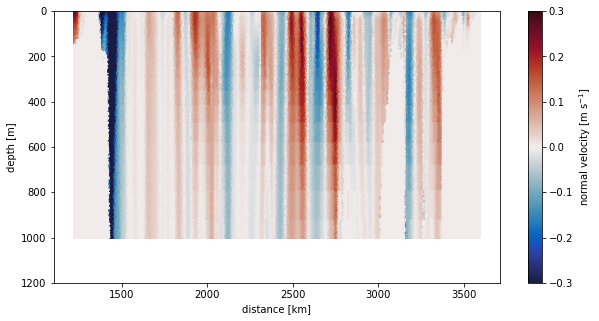

In [27]:
plot_section_sdist()

## Trim unwanted points from ParticleSet

Use initialised fields to remove land points. We test `temp == 0.0` (the mask value over land).


In [28]:
t = np.array([p.temp for p in pset])
# u = np.array([p.uvel for p in pset])
# v = np.array([p.vvel for p in pset])
pset.remove_indices(np.argwhere(t == 0).flatten())
# pset.remove(np.argwhere(x * y * z == 0).flatten())
print(len(pset))

2099728


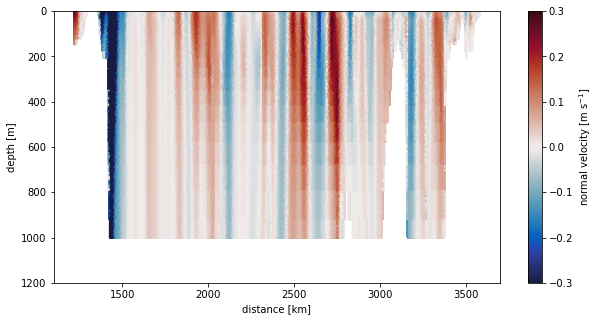

In [29]:
plot_section_sdist()

### Test velocity normal to section

#### Velocity conversions from degrees lat/lon per second to m/s

In [30]:
u = np.array([p.uvel for p in pset])
v = np.array([p.vvel for p in pset])


In [31]:
u=u * degree2km * 1000.0 * np.cos(np.radians(pset.lat))
v=v * degree2km * 1000.0

#### normal velocities

In [32]:
section_index = np.searchsorted(lonlat.lon,pset.lon)-1
u_normal = v * lonlatdiff.costheta[section_index].data - u * lonlatdiff.sintheta[section_index].data

In [33]:
abs(u_normal).max()

0.6469202121559818

#### remove particles randomly with probability proportional to normal speed

In [34]:
u_random = np.random.rand(len(u_normal))*max_current
pset.remove_indices(np.argwhere(abs(u_normal) < u_random).flatten())

print(len(pset))

61094


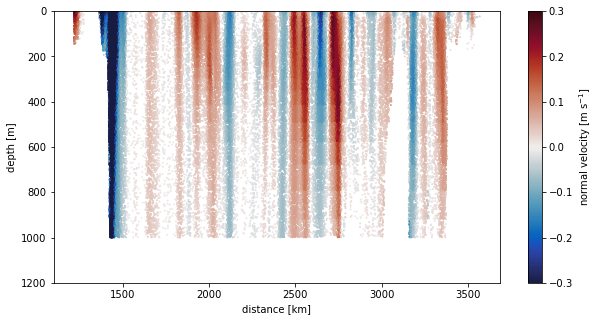

In [35]:
plot_section_sdist()

## Prepare output

We define an output file and specify the desired output frequency.

In [36]:
# output_filename = 'Parcels_IFFForwards_1m_June2016_2000.nc'
npart = str(len(pset))
output_filename = 'tracks_randomvel_mxl_'+sectionname+direction+year_str+month_str+day_str+'_N'+npart+'_D'+days+'_Rnd'+ seed+'.nc'
outfile = outpath / output_filename

print(outfile)
outputfile = pset.ParticleFile(
    name=outfile,
    outputdt=timedelta(hours=outputdt_in_hours)
)

../data/raw/tracks_randomvel_mxl_osnap_backward_20190702_N61094_D3650_Rnd14425.nc


## Execute the experiment

We'll evolve particles, log their positions and variables to the output buffer and finally export the output to a  the file.

### Run the experiment

In [37]:
%%time

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
pset.execute(
    custom_kernel,
    runtime=timedelta(days=runtime_in_days),    
    dt=timedelta(minutes=dt_in_minutes),      
    output_file=outputfile,
    recovery=recovery_cases
)

INFO: Temporary output files are stored in ../data/raw/out-DGSHOATA.


INFO: You can use "parcels_convert_npydir_to_netcdf ../data/raw/out-DGSHOATA" to convert these to a NetCDF file during the run.


N/A% (0 of 315360000.0) |                | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (864000.0 of 315360000.0) |         | Elapsed Time: 0:02:05 ETA:  12:38:29

  0% (1296000.0 of 315360000.0) |  | Elapsed Time: 0:04:12 ETA:  1 day, 1:42:29

  0% (1728000.0 of 315360000.0) |  | Elapsed Time: 0:06:18 ETA:  1 day, 1:31:03

  0% (2160000.0 of 315360000.0) |  | Elapsed Time: 0:08:25 ETA:  1 day, 1:34:42

  0% (2592000.0 of 315360000.0) |  | Elapsed Time: 0:10:33 ETA:  1 day, 1:40:01

  0% (3024000.0 of 315360000.0) |  | Elapsed Time: 0:12:39 ETA:  1 day, 1:22:23

  1% (3456000.0 of 315360000.0) |  | Elapsed Time: 0:14:49 ETA:  1 day, 1:58:51

  1% (3888000.0 of 315360000.0) |  | Elapsed Time: 0:16:55 ETA:  1 day, 1:15:35

  1% (4320000.0 of 315360000.0) |  | Elapsed Time: 0:19:01 ETA:  1 day, 1:13:34

  1% (4752000.0 of 315360000.0) |  | Elapsed Time: 0:21:07 ETA:  1 day, 1:09:43

  1% (5184000.0 of 315360000.0) |  | Elapsed Time: 0:23:16 ETA:  1 day, 1:41:41

  1% (5616000.0 of 315360000.0) |  | Elapsed Time: 0:25:25 ETA:  1 day, 1:40:46

  1% (6048000.0 of 315360000.0) |  | Elapsed Time: 0:27:34 ETA:  1 day, 1:36:44

  2% (6480000.0 of 315360000.0) |  | Elapsed Time: 0:29:44 ETA:  1 day, 1:51:07

  2% (6912000.0 of 315360000.0) |  | Elapsed Time: 0:31:52 ETA:  1 day, 1:29:06

  2% (7344000.0 of 315360000.0) |  | Elapsed Time: 0:34:00 ETA:  1 day, 1:17:09

  2% (7776000.0 of 315360000.0) |  | Elapsed Time: 0:36:05 ETA:  1 day, 0:47:13

  2% (8208000.0 of 315360000.0) |  | Elapsed Time: 0:38:10 ETA:  1 day, 0:39:31

  2% (8640000.0 of 315360000.0) |  | Elapsed Time: 0:40:17 ETA:  1 day, 1:03:38

  2% (9072000.0 of 315360000.0) |  | Elapsed Time: 0:42:24 ETA:  1 day, 1:01:09

  3% (9504000.0 of 315360000.0) |  | Elapsed Time: 0:44:32 ETA:  1 day, 1:09:13

  3% (9936000.0 of 315360000.0) |  | Elapsed Time: 0:46:41 ETA:  1 day, 1:14:51

  3% (10368000.0 of 315360000.0) | | Elapsed Time: 0:48:48 ETA:  1 day, 0:57:53

  3% (10800000.0 of 315360000.0) | | Elapsed Time: 0:50:55 ETA:  1 day, 0:53:17

  3% (11232000.0 of 315360000.0) | | Elapsed Time: 0:53:04 ETA:  1 day, 1:13:21

  3% (11664000.0 of 315360000.0) | | Elapsed Time: 0:55:13 ETA:  1 day, 1:10:21

  3% (12096000.0 of 315360000.0) | | Elapsed Time: 0:57:22 ETA:  1 day, 1:12:45

  3% (12528000.0 of 315360000.0) | | Elapsed Time: 0:59:31 ETA:  1 day, 1:09:15

  4% (12960000.0 of 315360000.0) | | Elapsed Time: 1:01:40 ETA:  1 day, 1:03:00

  4% (13392000.0 of 315360000.0) | | Elapsed Time: 1:03:49 ETA:  1 day, 1:04:39

  4% (13824000.0 of 315360000.0) | | Elapsed Time: 1:05:59 ETA:  1 day, 1:03:22

  4% (14256000.0 of 315360000.0) | | Elapsed Time: 1:08:07 ETA:  1 day, 0:55:34

  4% (14688000.0 of 315360000.0) | | Elapsed Time: 1:10:17 ETA:  1 day, 1:03:10

  4% (15120000.0 of 315360000.0) | | Elapsed Time: 1:12:26 ETA:  1 day, 0:50:48

  4% (15552000.0 of 315360000.0) | | Elapsed Time: 1:14:35 ETA:  1 day, 0:53:01

  5% (15984000.0 of 315360000.0) | | Elapsed Time: 1:16:45 ETA:  1 day, 0:59:52

  5% (16416000.0 of 315360000.0) | | Elapsed Time: 1:18:54 ETA:  1 day, 0:56:03

  5% (16848000.0 of 315360000.0) | | Elapsed Time: 1:21:04 ETA:  1 day, 0:51:18

  5% (17280000.0 of 315360000.0) | | Elapsed Time: 1:23:14 ETA:  1 day, 0:59:05

  5% (17712000.0 of 315360000.0) | | Elapsed Time: 1:25:24 ETA:  1 day, 0:45:54

  5% (18144000.0 of 315360000.0) | | Elapsed Time: 1:27:32 ETA:  1 day, 0:37:27

  5% (18576000.0 of 315360000.0) | | Elapsed Time: 1:29:41 ETA:  1 day, 0:36:14

  6% (19008000.0 of 315360000.0) | | Elapsed Time: 1:31:51 ETA:  1 day, 0:44:02

  6% (19440000.0 of 315360000.0) | | Elapsed Time: 1:34:01 ETA:  1 day, 0:38:26

  6% (19872000.0 of 315360000.0) | | Elapsed Time: 1:36:09 ETA:  1 day, 0:19:43

  6% (20304000.0 of 315360000.0) | | Elapsed Time: 1:38:17 ETA:  1 day, 0:19:50

  6% (20736000.0 of 315360000.0) | | Elapsed Time: 1:40:26 ETA:  1 day, 0:24:58

  6% (21168000.0 of 315360000.0) | | Elapsed Time: 1:42:37 ETA:  1 day, 0:48:15

  6% (21600000.0 of 315360000.0) |       | Elapsed Time: 1:44:44 ETA:  23:56:42

  6% (22032000.0 of 315360000.0) |       | Elapsed Time: 1:46:51 ETA:  23:56:01

  7% (22464000.0 of 315360000.0) | | Elapsed Time: 1:49:00 ETA:  1 day, 0:17:55

  7% (22896000.0 of 315360000.0) | | Elapsed Time: 1:51:09 ETA:  1 day, 0:16:51

  7% (23328000.0 of 315360000.0) | | Elapsed Time: 1:53:18 ETA:  1 day, 0:14:00

  7% (23760000.0 of 315360000.0) | | Elapsed Time: 1:55:26 ETA:  1 day, 0:02:07

  7% (24192000.0 of 315360000.0) |       | Elapsed Time: 1:57:34 ETA:  23:59:10

  7% (24624000.0 of 315360000.0) | | Elapsed Time: 1:59:43 ETA:  1 day, 0:03:07

  7% (25056000.0 of 315360000.0) |       | Elapsed Time: 2:01:51 ETA:  23:52:55

  8% (25488000.0 of 315360000.0) |       | Elapsed Time: 2:03:59 ETA:  23:56:33

  8% (25920000.0 of 315360000.0) |       | Elapsed Time: 2:06:06 ETA:  23:36:22

  8% (26352000.0 of 315360000.0) |       | Elapsed Time: 2:08:13 ETA:  23:35:13

  8% (26784000.0 of 315360000.0) |       | Elapsed Time: 2:10:20 ETA:  23:31:51

  8% (27216000.0 of 315360000.0) |       | Elapsed Time: 2:12:28 ETA:  23:45:59

  8% (27648000.0 of 315360000.0) |       | Elapsed Time: 2:14:36 ETA:  23:37:39

  8% (28080000.0 of 315360000.0) |       | Elapsed Time: 2:16:44 ETA:  23:40:45

  9% (28512000.0 of 315360000.0) |       | Elapsed Time: 2:18:51 ETA:  23:20:27

  9% (28944000.0 of 315360000.0) |       | Elapsed Time: 2:20:58 ETA:  23:32:23

  9% (29376000.0 of 315360000.0) |       | Elapsed Time: 2:23:06 ETA:  23:30:08

  9% (29808000.0 of 315360000.0) |       | Elapsed Time: 2:25:13 ETA:  23:19:31

  9% (30240000.0 of 315360000.0) |       | Elapsed Time: 2:27:21 ETA:  23:30:38

  9% (30672000.0 of 315360000.0) |       | Elapsed Time: 2:29:28 ETA:  23:05:58

  9% (31104000.0 of 315360000.0) |       | Elapsed Time: 2:31:35 ETA:  23:15:50

 10% (31536000.0 of 315360000.0) |       | Elapsed Time: 2:33:42 ETA:  23:12:44

 10% (31968000.0 of 315360000.0) |       | Elapsed Time: 2:35:49 ETA:  23:05:35

 10% (32400000.0 of 315360000.0) |       | Elapsed Time: 2:37:55 ETA:  23:00:51

 10% (32832000.0 of 315360000.0) |       | Elapsed Time: 2:40:03 ETA:  23:08:39

 10% (33264000.0 of 315360000.0) |       | Elapsed Time: 2:42:10 ETA:  23:01:28

 10% (33696000.0 of 315360000.0) |       | Elapsed Time: 2:44:17 ETA:  23:06:56

 10% (34128000.0 of 315360000.0) |       | Elapsed Time: 2:46:25 ETA:  23:02:18

 10% (34560000.0 of 315360000.0) |       | Elapsed Time: 2:48:31 ETA:  22:53:04

 11% (34992000.0 of 315360000.0) |       | Elapsed Time: 2:50:37 ETA:  22:40:37

 11% (35424000.0 of 315360000.0) |       | Elapsed Time: 2:52:44 ETA:  22:45:29

 11% (35856000.0 of 315360000.0) |       | Elapsed Time: 2:54:49 ETA:  22:33:39

 11% (36288000.0 of 315360000.0) |       | Elapsed Time: 2:56:56 ETA:  22:45:51

 11% (36720000.0 of 315360000.0) |       | Elapsed Time: 2:59:02 ETA:  22:38:39

 11% (37152000.0 of 315360000.0) |       | Elapsed Time: 3:01:10 ETA:  22:46:59

 11% (37584000.0 of 315360000.0) |       | Elapsed Time: 3:03:16 ETA:  22:32:20

 12% (38016000.0 of 315360000.0) |       | Elapsed Time: 3:05:21 ETA:  22:19:53

 12% (38448000.0 of 315360000.0) |       | Elapsed Time: 3:07:28 ETA:  22:31:39

 12% (38880000.0 of 315360000.0) |       | Elapsed Time: 3:09:33 ETA:  22:18:31

 12% (39312000.0 of 315360000.0) |       | Elapsed Time: 3:11:40 ETA:  22:34:35

 12% (39744000.0 of 315360000.0) |       | Elapsed Time: 3:13:47 ETA:  22:21:50

 12% (40176000.0 of 315360000.0) |       | Elapsed Time: 3:15:51 ETA:  22:05:32

 12% (40608000.0 of 315360000.0) |       | Elapsed Time: 3:17:58 ETA:  22:21:05

 13% (41040000.0 of 315360000.0) |       | Elapsed Time: 3:20:04 ETA:  22:16:43

 13% (41472000.0 of 315360000.0) |       | Elapsed Time: 3:22:10 ETA:  22:13:01

 13% (41904000.0 of 315360000.0) |       | Elapsed Time: 3:24:17 ETA:  22:19:13

 13% (42336000.0 of 315360000.0) |       | Elapsed Time: 3:26:23 ETA:  22:07:21

 13% (42768000.0 of 315360000.0) |       | Elapsed Time: 3:28:29 ETA:  22:04:30

 13% (43200000.0 of 315360000.0) |       | Elapsed Time: 3:30:35 ETA:  21:57:10

 13% (43632000.0 of 315360000.0) |       | Elapsed Time: 3:32:41 ETA:  22:02:38

 13% (44064000.0 of 315360000.0) |       | Elapsed Time: 3:34:47 ETA:  21:59:51

 14% (44496000.0 of 315360000.0) |       | Elapsed Time: 3:36:53 ETA:  21:56:01

 14% (44928000.0 of 315360000.0) |       | Elapsed Time: 3:38:59 ETA:  21:58:10

 14% (45360000.0 of 315360000.0) |#      | Elapsed Time: 3:41:05 ETA:  21:45:37

 14% (45792000.0 of 315360000.0) |#      | Elapsed Time: 3:43:11 ETA:  21:51:51

 14% (46224000.0 of 315360000.0) |#      | Elapsed Time: 3:45:17 ETA:  21:48:22

 14% (46656000.0 of 315360000.0) |#      | Elapsed Time: 3:47:23 ETA:  21:46:55

 14% (47088000.0 of 315360000.0) |#      | Elapsed Time: 3:49:29 ETA:  21:49:48

 15% (47520000.0 of 315360000.0) |#      | Elapsed Time: 3:51:36 ETA:  21:43:34

 15% (47952000.0 of 315360000.0) |#      | Elapsed Time: 3:53:41 ETA:  21:37:52

 15% (48384000.0 of 315360000.0) |#      | Elapsed Time: 3:55:48 ETA:  21:48:45

 15% (48816000.0 of 315360000.0) |#      | Elapsed Time: 3:57:55 ETA:  21:43:05

 15% (49248000.0 of 315360000.0) |#      | Elapsed Time: 4:00:01 ETA:  21:31:57

 15% (49680000.0 of 315360000.0) |#      | Elapsed Time: 4:02:07 ETA:  21:32:42

 15% (50112000.0 of 315360000.0) |#      | Elapsed Time: 4:04:14 ETA:  21:34:14

 16% (50544000.0 of 315360000.0) |#      | Elapsed Time: 4:06:18 ETA:  21:12:35

 16% (50976000.0 of 315360000.0) |#      | Elapsed Time: 4:08:23 ETA:  21:11:40

 16% (51408000.0 of 315360000.0) |#      | Elapsed Time: 4:10:28 ETA:  21:12:42

 16% (51840000.0 of 315360000.0) |#      | Elapsed Time: 4:12:34 ETA:  21:21:07

 16% (52272000.0 of 315360000.0) |#      | Elapsed Time: 4:14:40 ETA:  21:15:52

 16% (52704000.0 of 315360000.0) |#      | Elapsed Time: 4:16:44 ETA:  21:01:20

 16% (53136000.0 of 315360000.0) |#      | Elapsed Time: 4:18:50 ETA:  21:15:52

 16% (53568000.0 of 315360000.0) |#      | Elapsed Time: 4:20:55 ETA:  21:00:19

 17% (54000000.0 of 315360000.0) |#      | Elapsed Time: 4:22:59 ETA:  20:52:18

 17% (54432000.0 of 315360000.0) |#      | Elapsed Time: 4:25:04 ETA:  20:53:06

 17% (54864000.0 of 315360000.0) |#      | Elapsed Time: 4:27:08 ETA:  20:54:20

 17% (55296000.0 of 315360000.0) |#      | Elapsed Time: 4:29:13 ETA:  20:50:18

 17% (55728000.0 of 315360000.0) |#      | Elapsed Time: 4:31:17 ETA:  20:45:09

 17% (56160000.0 of 315360000.0) |#      | Elapsed Time: 4:33:23 ETA:  20:55:06

 17% (56592000.0 of 315360000.0) |#      | Elapsed Time: 4:35:26 ETA:  20:33:41

 18% (57024000.0 of 315360000.0) |#      | Elapsed Time: 4:37:32 ETA:  20:52:12

 18% (57456000.0 of 315360000.0) |#      | Elapsed Time: 4:39:37 ETA:  20:40:05

 18% (57888000.0 of 315360000.0) |#      | Elapsed Time: 4:41:41 ETA:  20:38:58

 18% (58320000.0 of 315360000.0) |#      | Elapsed Time: 4:43:46 ETA:  20:36:37

 18% (58752000.0 of 315360000.0) |#      | Elapsed Time: 4:45:50 ETA:  20:27:27

 18% (59184000.0 of 315360000.0) |#      | Elapsed Time: 4:47:55 ETA:  20:30:31

 18% (59616000.0 of 315360000.0) |#      | Elapsed Time: 4:49:59 ETA:  20:26:15

 19% (60048000.0 of 315360000.0) |#      | Elapsed Time: 4:52:03 ETA:  20:22:53

 19% (60480000.0 of 315360000.0) |#      | Elapsed Time: 4:54:08 ETA:  20:26:35

 19% (60912000.0 of 315360000.0) |#      | Elapsed Time: 4:56:12 ETA:  20:23:13

 19% (61344000.0 of 315360000.0) |#      | Elapsed Time: 4:58:17 ETA:  20:20:12

 19% (61776000.0 of 315360000.0) |#      | Elapsed Time: 5:00:21 ETA:  20:12:14

 19% (62208000.0 of 315360000.0) |#      | Elapsed Time: 5:02:23 ETA:  19:54:09

 19% (62640000.0 of 315360000.0) |#      | Elapsed Time: 5:04:26 ETA:  20:03:28

 20% (63072000.0 of 315360000.0) |#      | Elapsed Time: 5:06:30 ETA:  20:05:22

 20% (63504000.0 of 315360000.0) |#      | Elapsed Time: 5:08:33 ETA:  19:51:08

 20% (63936000.0 of 315360000.0) |#      | Elapsed Time: 5:10:35 ETA:  19:47:13

 20% (64368000.0 of 315360000.0) |#      | Elapsed Time: 5:12:39 ETA:  19:56:15

 20% (64800000.0 of 315360000.0) |#      | Elapsed Time: 5:14:43 ETA:  19:57:41

 20% (65232000.0 of 315360000.0) |#      | Elapsed Time: 5:16:45 ETA:  19:39:59

 20% (65664000.0 of 315360000.0) |#      | Elapsed Time: 5:18:49 ETA:  19:51:00

 20% (66096000.0 of 315360000.0) |#      | Elapsed Time: 5:20:52 ETA:  19:44:27

 21% (66528000.0 of 315360000.0) |#      | Elapsed Time: 5:22:56 ETA:  19:52:59

 21% (66960000.0 of 315360000.0) |#      | Elapsed Time: 5:24:59 ETA:  19:41:55

 21% (67392000.0 of 315360000.0) |#      | Elapsed Time: 5:27:04 ETA:  19:48:38

 21% (67824000.0 of 315360000.0) |#      | Elapsed Time: 5:29:07 ETA:  19:40:37

 21% (68256000.0 of 315360000.0) |#      | Elapsed Time: 5:31:10 ETA:  19:27:41

 21% (68688000.0 of 315360000.0) |#      | Elapsed Time: 5:33:12 ETA:  19:26:25

 21% (69120000.0 of 315360000.0) |#      | Elapsed Time: 5:35:15 ETA:  19:24:22

 22% (69552000.0 of 315360000.0) |#      | Elapsed Time: 5:37:18 ETA:  19:26:36

 22% (69984000.0 of 315360000.0) |#      | Elapsed Time: 5:39:22 ETA:  19:31:30

 22% (70416000.0 of 315360000.0) |#      | Elapsed Time: 5:41:24 ETA:  19:18:58

 22% (70848000.0 of 315360000.0) |#      | Elapsed Time: 5:43:27 ETA:  19:19:57

 22% (71280000.0 of 315360000.0) |#      | Elapsed Time: 5:45:30 ETA:  19:17:22

 22% (71712000.0 of 315360000.0) |#      | Elapsed Time: 5:47:32 ETA:  19:08:38

 22% (72144000.0 of 315360000.0) |#      | Elapsed Time: 5:49:35 ETA:  19:10:14

 23% (72576000.0 of 315360000.0) |#      | Elapsed Time: 5:51:37 ETA:  19:04:58

 23% (73008000.0 of 315360000.0) |#      | Elapsed Time: 5:53:39 ETA:  18:59:24

 23% (73440000.0 of 315360000.0) |#      | Elapsed Time: 5:55:42 ETA:  19:04:48

 23% (73872000.0 of 315360000.0) |#      | Elapsed Time: 5:57:45 ETA:  19:04:21

 23% (74304000.0 of 315360000.0) |#      | Elapsed Time: 5:59:47 ETA:  18:59:12

 23% (74736000.0 of 315360000.0) |#      | Elapsed Time: 6:01:50 ETA:  18:58:17

 23% (75168000.0 of 315360000.0) |#      | Elapsed Time: 6:03:51 ETA:  18:39:33

 23% (75600000.0 of 315360000.0) |#      | Elapsed Time: 6:05:52 ETA:  18:45:31

 24% (76032000.0 of 315360000.0) |#      | Elapsed Time: 6:07:54 ETA:  18:42:58

 24% (76464000.0 of 315360000.0) |#      | Elapsed Time: 6:09:55 ETA:  18:36:59

 24% (76896000.0 of 315360000.0) |#      | Elapsed Time: 6:11:57 ETA:  18:44:45

 24% (77328000.0 of 315360000.0) |#      | Elapsed Time: 6:13:59 ETA:  18:36:11

 24% (77760000.0 of 315360000.0) |#      | Elapsed Time: 6:16:00 ETA:  18:30:07

 24% (78192000.0 of 315360000.0) |#      | Elapsed Time: 6:18:01 ETA:  18:24:07

 24% (78624000.0 of 315360000.0) |#      | Elapsed Time: 6:20:01 ETA:  18:21:53

 25% (79056000.0 of 315360000.0) |#      | Elapsed Time: 6:22:02 ETA:  18:21:38

 25% (79488000.0 of 315360000.0) |#      | Elapsed Time: 6:24:03 ETA:  18:23:16

 25% (79920000.0 of 315360000.0) |#      | Elapsed Time: 6:26:04 ETA:  18:15:04

 25% (80352000.0 of 315360000.0) |#      | Elapsed Time: 6:28:04 ETA:  18:11:13

 25% (80784000.0 of 315360000.0) |#      | Elapsed Time: 6:30:05 ETA:  18:15:27

 25% (81216000.0 of 315360000.0) |#      | Elapsed Time: 6:32:06 ETA:  18:14:25

 25% (81648000.0 of 315360000.0) |#      | Elapsed Time: 6:34:07 ETA:  18:11:04

 26% (82080000.0 of 315360000.0) |#      | Elapsed Time: 6:36:10 ETA:  18:23:27

 26% (82512000.0 of 315360000.0) |#      | Elapsed Time: 6:38:12 ETA:  18:11:26

 26% (82944000.0 of 315360000.0) |#      | Elapsed Time: 6:40:13 ETA:  18:09:05

 26% (83376000.0 of 315360000.0) |#      | Elapsed Time: 6:42:14 ETA:  18:04:08

 26% (83808000.0 of 315360000.0) |#      | Elapsed Time: 6:44:16 ETA:  18:05:24

 26% (84240000.0 of 315360000.0) |#      | Elapsed Time: 6:46:16 ETA:  17:56:12

 26% (84672000.0 of 315360000.0) |#      | Elapsed Time: 6:48:17 ETA:  17:56:07

 26% (85104000.0 of 315360000.0) |#      | Elapsed Time: 6:50:19 ETA:  18:01:47

 27% (85536000.0 of 315360000.0) |#      | Elapsed Time: 6:52:20 ETA:  17:54:59

 27% (85968000.0 of 315360000.0) |#      | Elapsed Time: 6:54:21 ETA:  17:45:47

 27% (86400000.0 of 315360000.0) |#      | Elapsed Time: 6:56:21 ETA:  17:42:19

 27% (86832000.0 of 315360000.0) |#      | Elapsed Time: 6:58:20 ETA:  17:28:22

 27% (87264000.0 of 315360000.0) |#      | Elapsed Time: 7:00:19 ETA:  17:25:47

 27% (87696000.0 of 315360000.0) |#      | Elapsed Time: 7:02:18 ETA:  17:28:01

 27% (88128000.0 of 315360000.0) |#      | Elapsed Time: 7:04:18 ETA:  17:30:14

 28% (88560000.0 of 315360000.0) |#      | Elapsed Time: 7:06:17 ETA:  17:24:29

 28% (88992000.0 of 315360000.0) |#      | Elapsed Time: 7:08:16 ETA:  17:17:04

 28% (89424000.0 of 315360000.0) |#      | Elapsed Time: 7:10:15 ETA:  17:15:59

 28% (89856000.0 of 315360000.0) |#      | Elapsed Time: 7:12:13 ETA:  17:07:37

 28% (90288000.0 of 315360000.0) |##     | Elapsed Time: 7:14:11 ETA:  17:06:52

 28% (90720000.0 of 315360000.0) |##     | Elapsed Time: 7:16:09 ETA:  17:02:08

 28% (91152000.0 of 315360000.0) |##     | Elapsed Time: 7:18:07 ETA:  16:56:30

 29% (91584000.0 of 315360000.0) |##     | Elapsed Time: 7:20:05 ETA:  17:03:40

 29% (92016000.0 of 315360000.0) |##     | Elapsed Time: 7:22:04 ETA:  17:02:23

 29% (92448000.0 of 315360000.0) |##     | Elapsed Time: 7:24:02 ETA:  16:54:42

 29% (92880000.0 of 315360000.0) |##     | Elapsed Time: 7:26:01 ETA:  17:04:09

 29% (93312000.0 of 315360000.0) |##     | Elapsed Time: 7:27:59 ETA:  16:52:25

 29% (93744000.0 of 315360000.0) |##     | Elapsed Time: 7:29:57 ETA:  16:48:05

 29% (94176000.0 of 315360000.0) |##     | Elapsed Time: 7:31:56 ETA:  16:57:14

 30% (94608000.0 of 315360000.0) |##     | Elapsed Time: 7:33:55 ETA:  16:49:00

 30% (95040000.0 of 315360000.0) |##     | Elapsed Time: 7:35:53 ETA:  16:43:12

 30% (95472000.0 of 315360000.0) |##     | Elapsed Time: 7:37:50 ETA:  16:34:09

 30% (95904000.0 of 315360000.0) |##     | Elapsed Time: 7:39:48 ETA:  16:36:39

 30% (96336000.0 of 315360000.0) |##     | Elapsed Time: 7:41:45 ETA:  16:26:03

 30% (96768000.0 of 315360000.0) |##     | Elapsed Time: 7:43:43 ETA:  16:38:42

 30% (97200000.0 of 315360000.0) |##     | Elapsed Time: 7:45:41 ETA:  16:35:36

 30% (97632000.0 of 315360000.0) |##     | Elapsed Time: 7:47:39 ETA:  16:32:23

 31% (98064000.0 of 315360000.0) |##     | Elapsed Time: 7:49:37 ETA:  16:26:50

 31% (98496000.0 of 315360000.0) |##     | Elapsed Time: 7:51:33 ETA:  16:13:44

 31% (98928000.0 of 315360000.0) |##     | Elapsed Time: 7:53:30 ETA:  16:12:48

 31% (99360000.0 of 315360000.0) |##     | Elapsed Time: 7:55:26 ETA:  16:06:32

 31% (99792000.0 of 315360000.0) |##     | Elapsed Time: 7:57:22 ETA:  16:07:18

 31% (100224000.0 of 315360000.0) |#     | Elapsed Time: 7:59:18 ETA:  16:02:02

 31% (100656000.0 of 315360000.0) |#     | Elapsed Time: 8:01:14 ETA:  15:57:51

 32% (101088000.0 of 315360000.0) |#     | Elapsed Time: 8:03:10 ETA:  15:59:37

 32% (101520000.0 of 315360000.0) |#     | Elapsed Time: 8:05:07 ETA:  16:02:27

 32% (101952000.0 of 315360000.0) |#     | Elapsed Time: 8:07:02 ETA:  15:51:07

 32% (102384000.0 of 315360000.0) |#     | Elapsed Time: 8:08:58 ETA:  15:56:23

 32% (102816000.0 of 315360000.0) |#     | Elapsed Time: 8:10:54 ETA:  15:47:45

 32% (103248000.0 of 315360000.0) |#     | Elapsed Time: 8:12:49 ETA:  15:44:00

 32% (103680000.0 of 315360000.0) |#     | Elapsed Time: 8:14:43 ETA:  15:28:59

 33% (104112000.0 of 315360000.0) |#     | Elapsed Time: 8:16:39 ETA:  15:40:43

 33% (104544000.0 of 315360000.0) |#     | Elapsed Time: 8:18:33 ETA:  15:31:59

 33% (104976000.0 of 315360000.0) |#     | Elapsed Time: 8:20:28 ETA:  15:33:54

 33% (105408000.0 of 315360000.0) |##    | Elapsed Time: 8:21:58 ETA:  12:09:56

 33% (105451200.0 of 315360000.0) || Elapsed Time: 8:22:36 ETA:  2 days, 3:27:13

 33% (105840000.0 of 315360000.0) |##    | Elapsed Time: 8:23:59 ETA:  12:16:55

 33% (105926400.0 of 315360000.0) || Elapsed Time: 8:24:45 ETA:  1 day, 7:21:29

 33% (106272000.0 of 315360000.0) |##    | Elapsed Time: 8:25:58 ETA:  12:17:25

 33% (106358400.0 of 315360000.0) || Elapsed Time: 8:26:45 ETA:  1 day, 7:21:42

 33% (106704000.0 of 315360000.0) |##    | Elapsed Time: 8:27:58 ETA:  12:17:49

 33% (106790400.0 of 315360000.0) || Elapsed Time: 8:28:46 ETA:  1 day, 7:46:56

 33% (107136000.0 of 315360000.0) |##    | Elapsed Time: 8:29:59 ETA:  12:12:24

 34% (107222400.0 of 315360000.0) || Elapsed Time: 8:30:46 ETA:  1 day, 7:45:21

 34% (107568000.0 of 315360000.0) |##    | Elapsed Time: 8:31:59 ETA:  12:08:42

 34% (107654400.0 of 315360000.0) || Elapsed Time: 8:32:45 ETA:  1 day, 7:03:54

 34% (108000000.0 of 315360000.0) |##    | Elapsed Time: 8:33:59 ETA:  12:15:32

 34% (108086400.0 of 315360000.0) || Elapsed Time: 8:34:46 ETA:  1 day, 7:06:25

 34% (108432000.0 of 315360000.0) |##    | Elapsed Time: 8:35:59 ETA:  12:09:57

 34% (108518400.0 of 315360000.0) || Elapsed Time: 8:36:45 ETA:  1 day, 6:53:15

 34% (108864000.0 of 315360000.0) |##    | Elapsed Time: 8:37:57 ETA:  11:59:07

 34% (108950400.0 of 315360000.0) || Elapsed Time: 8:38:42 ETA:  1 day, 5:55:27

 34% (109296000.0 of 315360000.0) |##    | Elapsed Time: 8:39:55 ETA:  11:59:38

 34% (109382400.0 of 315360000.0) || Elapsed Time: 8:40:40 ETA:  1 day, 5:50:31

 34% (109728000.0 of 315360000.0) |##    | Elapsed Time: 8:41:52 ETA:  11:59:00

 34% (109814400.0 of 315360000.0) || Elapsed Time: 8:42:38 ETA:  1 day, 5:53:42

 34% (110160000.0 of 315360000.0) |##    | Elapsed Time: 8:43:50 ETA:  11:55:07

 34% (110246400.0 of 315360000.0) || Elapsed Time: 8:44:36 ETA:  1 day, 6:09:49

 35% (110592000.0 of 315360000.0) |##    | Elapsed Time: 8:45:48 ETA:  11:51:18

 35% (110678400.0 of 315360000.0) || Elapsed Time: 8:46:33 ETA:  1 day, 5:32:02

 35% (111024000.0 of 315360000.0) |##    | Elapsed Time: 8:47:45 ETA:  11:54:29

 35% (111110400.0 of 315360000.0) || Elapsed Time: 8:48:32 ETA:  1 day, 6:36:48

 35% (111456000.0 of 315360000.0) |##    | Elapsed Time: 8:49:45 ETA:  11:59:41

 35% (111542400.0 of 315360000.0) || Elapsed Time: 8:50:30 ETA:  1 day, 5:49:42

 35% (111888000.0 of 315360000.0) |##    | Elapsed Time: 8:51:43 ETA:  11:53:31

 35% (111974400.0 of 315360000.0) || Elapsed Time: 8:52:30 ETA:  1 day, 6:26:02

 35% (112320000.0 of 315360000.0) |##    | Elapsed Time: 8:53:42 ETA:  11:46:59

 35% (112406400.0 of 315360000.0) || Elapsed Time: 8:54:28 ETA:  1 day, 6:21:04

 35% (112752000.0 of 315360000.0) |##    | Elapsed Time: 8:55:40 ETA:  11:44:41

 35% (112838400.0 of 315360000.0) || Elapsed Time: 8:56:28 ETA:  1 day, 6:39:58

 35% (113184000.0 of 315360000.0) |##    | Elapsed Time: 8:57:39 ETA:  11:36:32

 35% (113270400.0 of 315360000.0) || Elapsed Time: 8:58:26 ETA:  1 day, 6:27:45

 36% (113616000.0 of 315360000.0) |##    | Elapsed Time: 8:59:37 ETA:  11:36:11

 36% (113702400.0 of 315360000.0) || Elapsed Time: 9:00:25 ETA:  1 day, 6:31:35

 36% (114048000.0 of 315360000.0) |##    | Elapsed Time: 9:01:36 ETA:  11:38:13

 36% (114134400.0 of 315360000.0) || Elapsed Time: 9:02:24 ETA:  1 day, 6:31:09

 36% (114480000.0 of 315360000.0) |##    | Elapsed Time: 9:03:36 ETA:  11:43:24

 36% (114566400.0 of 315360000.0) || Elapsed Time: 9:04:22 ETA:  1 day, 5:22:55

 36% (114912000.0 of 315360000.0) |##    | Elapsed Time: 9:05:33 ETA:  11:28:06

 36% (114998400.0 of 315360000.0) || Elapsed Time: 9:06:20 ETA:  1 day, 6:33:57

 36% (115344000.0 of 315360000.0) |##    | Elapsed Time: 9:07:33 ETA:  11:39:26

 36% (115430400.0 of 315360000.0) || Elapsed Time: 9:08:20 ETA:  1 day, 6:00:20

 36% (115776000.0 of 315360000.0) |##    | Elapsed Time: 9:09:32 ETA:  11:32:33

 36% (115862400.0 of 315360000.0) || Elapsed Time: 9:10:18 ETA:  1 day, 5:59:51

 36% (116208000.0 of 315360000.0) |##    | Elapsed Time: 9:11:30 ETA:  11:31:40

 36% (116294400.0 of 315360000.0) || Elapsed Time: 9:12:18 ETA:  1 day, 6:19:46

 36% (116640000.0 of 315360000.0) |##    | Elapsed Time: 9:13:30 ETA:  11:30:45

 37% (116726400.0 of 315360000.0) || Elapsed Time: 9:14:16 ETA:  1 day, 5:42:30

 37% (117072000.0 of 315360000.0) |##    | Elapsed Time: 9:15:27 ETA:  11:20:08

 37% (117158400.0 of 315360000.0) || Elapsed Time: 9:16:13 ETA:  1 day, 5:16:56

 37% (117504000.0 of 315360000.0) |##    | Elapsed Time: 9:17:25 ETA:  11:20:34

 37% (117590400.0 of 315360000.0) || Elapsed Time: 9:18:10 ETA:  1 day, 5:05:32

 37% (117936000.0 of 315360000.0) |##    | Elapsed Time: 9:19:21 ETA:  11:13:48

 37% (118022400.0 of 315360000.0) || Elapsed Time: 9:20:06 ETA:  1 day, 4:39:23

 37% (118368000.0 of 315360000.0) |##    | Elapsed Time: 9:21:17 ETA:  11:13:33

 37% (118454400.0 of 315360000.0) || Elapsed Time: 9:22:03 ETA:  1 day, 4:56:36

 37% (118800000.0 of 315360000.0) |##    | Elapsed Time: 9:23:14 ETA:  11:10:34

 37% (118886400.0 of 315360000.0) || Elapsed Time: 9:23:59 ETA:  1 day, 4:49:34

 37% (119232000.0 of 315360000.0) |##    | Elapsed Time: 9:25:12 ETA:  11:23:57

 37% (119318400.0 of 315360000.0) || Elapsed Time: 9:25:57 ETA:  1 day, 4:41:45

 37% (119664000.0 of 315360000.0) |##    | Elapsed Time: 9:27:08 ETA:  11:06:51

 37% (119750400.0 of 315360000.0) || Elapsed Time: 9:27:54 ETA:  1 day, 4:42:22

 38% (120096000.0 of 315360000.0) |##    | Elapsed Time: 9:29:04 ETA:  11:05:12

 38% (120182400.0 of 315360000.0) || Elapsed Time: 9:29:50 ETA:  1 day, 4:48:01

 38% (120528000.0 of 315360000.0) |##    | Elapsed Time: 9:31:01 ETA:  11:03:29

 38% (120614400.0 of 315360000.0) || Elapsed Time: 9:31:47 ETA:  1 day, 4:44:42

 38% (120960000.0 of 315360000.0) |##    | Elapsed Time: 9:32:57 ETA:  10:57:07

 38% (121046400.0 of 315360000.0) || Elapsed Time: 9:33:42 ETA:  1 day, 4:20:44

 38% (121392000.0 of 315360000.0) |##    | Elapsed Time: 9:34:53 ETA:  11:00:36

 38% (121478400.0 of 315360000.0) || Elapsed Time: 9:35:38 ETA:  1 day, 3:56:41

 38% (121824000.0 of 315360000.0) |##    | Elapsed Time: 9:36:48 ETA:  10:55:58

 38% (121910400.0 of 315360000.0) || Elapsed Time: 9:37:34 ETA:  1 day, 4:32:25

 38% (122256000.0 of 315360000.0) |##    | Elapsed Time: 9:38:45 ETA:  11:01:25

 38% (122342400.0 of 315360000.0) || Elapsed Time: 9:39:30 ETA:  1 day, 4:09:01

 38% (122688000.0 of 315360000.0) |##    | Elapsed Time: 9:40:41 ETA:  10:56:04

 38% (122774400.0 of 315360000.0) || Elapsed Time: 9:41:26 ETA:  1 day, 4:08:21

 39% (123120000.0 of 315360000.0) |##    | Elapsed Time: 9:42:36 ETA:  10:49:48

 39% (123206400.0 of 315360000.0) || Elapsed Time: 9:43:23 ETA:  1 day, 4:37:06

 39% (123552000.0 of 315360000.0) |##    | Elapsed Time: 9:44:33 ETA:  10:48:22

 39% (123638400.0 of 315360000.0) || Elapsed Time: 9:45:20 ETA:  1 day, 5:03:22

 39% (123984000.0 of 315360000.0) |##    | Elapsed Time: 9:46:30 ETA:  10:50:44

 39% (124070400.0 of 315360000.0) || Elapsed Time: 9:47:17 ETA:  1 day, 4:47:40

 39% (124416000.0 of 315360000.0) |##    | Elapsed Time: 9:48:27 ETA:  10:47:19

 39% (124502400.0 of 315360000.0) || Elapsed Time: 9:49:15 ETA:  1 day, 4:52:23

 39% (124848000.0 of 315360000.0) |##    | Elapsed Time: 9:50:25 ETA:  10:46:54

 39% (124934400.0 of 315360000.0) || Elapsed Time: 9:51:12 ETA:  1 day, 4:39:43

 39% (125280000.0 of 315360000.0) |##    | Elapsed Time: 9:52:22 ETA:  10:40:47

 39% (125366400.0 of 315360000.0) || Elapsed Time: 9:53:07 ETA:  1 day, 3:54:45

 39% (125712000.0 of 315360000.0) |##    | Elapsed Time: 9:54:18 ETA:  10:48:06

 39% (125798400.0 of 315360000.0) || Elapsed Time: 9:55:04 ETA:  1 day, 3:59:59

 40% (126144000.0 of 315360000.0) |##    | Elapsed Time: 9:56:14 ETA:  10:36:45

 40% (126230400.0 of 315360000.0) || Elapsed Time: 9:56:59 ETA:  1 day, 3:32:30

 40% (126576000.0 of 315360000.0) |##    | Elapsed Time: 9:58:09 ETA:  10:35:27

 40% (126662400.0 of 315360000.0) || Elapsed Time: 9:58:54 ETA:  1 day, 3:27:44

 40% (127008000.0 of 315360000.0) |##   | Elapsed Time: 10:00:04 ETA:  10:33:17

 40% (127094400.0 of 315360000.0) || Elapsed Time: 10:00:49 ETA:  1 day, 3:00:44

 40% (127440000.0 of 315360000.0) |##   | Elapsed Time: 10:01:59 ETA:  10:33:37

 40% (127526400.0 of 315360000.0) || Elapsed Time: 10:02:44 ETA:  1 day, 3:21:36

 40% (127872000.0 of 315360000.0) |##   | Elapsed Time: 10:03:54 ETA:  10:32:59

 40% (127958400.0 of 315360000.0) || Elapsed Time: 10:04:39 ETA:  1 day, 3:09:06

 40% (128304000.0 of 315360000.0) |##   | Elapsed Time: 10:05:49 ETA:  10:28:39

 40% (128390400.0 of 315360000.0) || Elapsed Time: 10:06:34 ETA:  1 day, 3:22:32

 40% (128736000.0 of 315360000.0) |##   | Elapsed Time: 10:07:43 ETA:  10:22:42

 40% (128822400.0 of 315360000.0) || Elapsed Time: 10:08:30 ETA:  1 day, 3:51:34

 40% (129168000.0 of 315360000.0) |##   | Elapsed Time: 10:09:39 ETA:  10:21:44

 40% (129254400.0 of 315360000.0) || Elapsed Time: 10:10:24 ETA:  1 day, 2:38:19

 41% (129600000.0 of 315360000.0) |##   | Elapsed Time: 10:11:33 ETA:  10:20:36

 41% (129686400.0 of 315360000.0) || Elapsed Time: 10:12:18 ETA:  1 day, 2:50:36

 41% (130032000.0 of 315360000.0) |##   | Elapsed Time: 10:13:27 ETA:  10:20:37

 41% (130118400.0 of 315360000.0) || Elapsed Time: 10:14:13 ETA:  1 day, 2:57:24

 41% (130464000.0 of 315360000.0) |##   | Elapsed Time: 10:15:22 ETA:  10:16:17

 41% (130550400.0 of 315360000.0) || Elapsed Time: 10:16:07 ETA:  1 day, 2:47:20

 41% (130896000.0 of 315360000.0) |##   | Elapsed Time: 10:17:16 ETA:  10:20:38

 41% (130982400.0 of 315360000.0) || Elapsed Time: 10:18:02 ETA:  1 day, 2:59:35

 41% (131328000.0 of 315360000.0) |##   | Elapsed Time: 10:19:11 ETA:  10:13:51

 41% (131414400.0 of 315360000.0) || Elapsed Time: 10:19:56 ETA:  1 day, 2:22:24

 41% (131760000.0 of 315360000.0) |##   | Elapsed Time: 10:21:05 ETA:  10:11:01

 41% (131846400.0 of 315360000.0) || Elapsed Time: 10:21:50 ETA:  1 day, 2:41:10

 41% (132192000.0 of 315360000.0) |##   | Elapsed Time: 10:22:59 ETA:  10:09:09

 41% (132278400.0 of 315360000.0) || Elapsed Time: 10:23:45 ETA:  1 day, 2:55:21

 42% (132624000.0 of 315360000.0) |##   | Elapsed Time: 10:24:54 ETA:  10:12:44

 42% (132710400.0 of 315360000.0) || Elapsed Time: 10:25:41 ETA:  1 day, 3:11:13

 42% (133056000.0 of 315360000.0) |##   | Elapsed Time: 10:26:50 ETA:  10:07:29

 42% (133142400.0 of 315360000.0) || Elapsed Time: 10:27:36 ETA:  1 day, 3:12:03

 42% (133488000.0 of 315360000.0) |##   | Elapsed Time: 10:28:46 ETA:  10:10:20

 42% (133574400.0 of 315360000.0) || Elapsed Time: 10:29:31 ETA:  1 day, 2:40:00

 42% (133920000.0 of 315360000.0) |##   | Elapsed Time: 10:30:40 ETA:   9:58:46

 42% (134006400.0 of 315360000.0) || Elapsed Time: 10:31:24 ETA:  1 day, 1:49:53

 42% (134352000.0 of 315360000.0) |##   | Elapsed Time: 10:32:33 ETA:   9:57:42

 42% (134438400.0 of 315360000.0) || Elapsed Time: 10:33:18 ETA:  1 day, 2:19:18

 42% (134784000.0 of 315360000.0) |##   | Elapsed Time: 10:34:26 ETA:   9:56:02

 42% (134870400.0 of 315360000.0) || Elapsed Time: 10:35:11 ETA:  1 day, 1:58:06

 42% (135216000.0 of 315360000.0) |##   | Elapsed Time: 10:36:19 ETA:   9:54:11

 42% (135302400.0 of 315360000.0) || Elapsed Time: 10:37:05 ETA:  1 day, 2:25:02

 43% (135648000.0 of 315360000.0) |##   | Elapsed Time: 10:38:13 ETA:   9:52:26

 43% (135734400.0 of 315360000.0) || Elapsed Time: 10:38:58 ETA:  1 day, 1:34:46

 43% (136080000.0 of 315360000.0) |##   | Elapsed Time: 10:40:06 ETA:   9:54:20

 43% (136166400.0 of 315360000.0) || Elapsed Time: 10:40:51 ETA:  1 day, 1:56:24

 43% (136512000.0 of 315360000.0) |##   | Elapsed Time: 10:42:01 ETA:   9:56:53

 43% (136598400.0 of 315360000.0) || Elapsed Time: 10:42:45 ETA:  1 day, 1:44:04

 43% (136944000.0 of 315360000.0) |##   | Elapsed Time: 10:43:54 ETA:   9:47:04

 43% (137030400.0 of 315360000.0) || Elapsed Time: 10:44:39 ETA:  1 day, 1:49:19

 43% (137376000.0 of 315360000.0) |##   | Elapsed Time: 10:45:47 ETA:   9:49:07

 43% (137462400.0 of 315360000.0) || Elapsed Time: 10:46:33 ETA:  1 day, 2:07:49

 43% (137808000.0 of 315360000.0) |##   | Elapsed Time: 10:47:41 ETA:   9:44:06

 43% (137894400.0 of 315360000.0) || Elapsed Time: 10:48:27 ETA:  1 day, 2:03:32

 43% (138240000.0 of 315360000.0) |##   | Elapsed Time: 10:49:35 ETA:   9:41:12

 43% (138326400.0 of 315360000.0) || Elapsed Time: 10:50:20 ETA:  1 day, 1:55:04

 43% (138672000.0 of 315360000.0) |##   | Elapsed Time: 10:51:28 ETA:   9:39:13

 44% (138758400.0 of 315360000.0) || Elapsed Time: 10:52:14 ETA:  1 day, 2:02:02

 44% (139104000.0 of 315360000.0) |##   | Elapsed Time: 10:53:23 ETA:   9:43:38

 44% (139190400.0 of 315360000.0) || Elapsed Time: 10:54:09 ETA:  1 day, 1:56:37

 44% (139536000.0 of 315360000.0) |##   | Elapsed Time: 10:55:17 ETA:   9:42:25

 44% (139622400.0 of 315360000.0) || Elapsed Time: 10:56:03 ETA:  1 day, 1:40:18

 44% (139968000.0 of 315360000.0) |##   | Elapsed Time: 10:57:11 ETA:   9:32:45

 44% (140054400.0 of 315360000.0) || Elapsed Time: 10:57:56 ETA:  1 day, 1:32:15

 44% (140400000.0 of 315360000.0) |##   | Elapsed Time: 10:59:04 ETA:   9:33:19

 44% (140486400.0 of 315360000.0) || Elapsed Time: 10:59:49 ETA:  1 day, 1:24:18

 44% (140832000.0 of 315360000.0) |##   | Elapsed Time: 11:00:57 ETA:   9:32:18

 44% (140918400.0 of 315360000.0) || Elapsed Time: 11:01:42 ETA:  1 day, 1:04:55

 44% (141264000.0 of 315360000.0) |##   | Elapsed Time: 11:02:49 ETA:   9:26:46

 44% (141350400.0 of 315360000.0) || Elapsed Time: 11:03:35 ETA:  1 day, 1:24:00

 44% (141696000.0 of 315360000.0) |##   | Elapsed Time: 11:04:42 ETA:   9:21:54

 44% (141782400.0 of 315360000.0) || Elapsed Time: 11:05:27 ETA:  1 day, 0:57:55

 45% (142128000.0 of 315360000.0) |##   | Elapsed Time: 11:06:34 ETA:   9:26:28

 45% (142214400.0 of 315360000.0) || Elapsed Time: 11:07:20 ETA:  1 day, 1:19:31

 45% (142560000.0 of 315360000.0) |##   | Elapsed Time: 11:08:27 ETA:   9:18:02

 45% (142646400.0 of 315360000.0) || Elapsed Time: 11:09:11 ETA:  1 day, 0:36:19

 45% (142992000.0 of 315360000.0) |##   | Elapsed Time: 11:10:18 ETA:   9:18:59

 45% (143078400.0 of 315360000.0) || Elapsed Time: 11:11:03 ETA:  1 day, 0:39:38

 45% (143424000.0 of 315360000.0) |##   | Elapsed Time: 11:12:10 ETA:   9:18:10

 45% (143510400.0 of 315360000.0) || Elapsed Time: 11:12:55 ETA:  1 day, 0:43:23

 45% (143856000.0 of 315360000.0) |##   | Elapsed Time: 11:14:03 ETA:   9:19:45

 45% (143942400.0 of 315360000.0) || Elapsed Time: 11:14:47 ETA:  1 day, 0:20:15

 45% (144288000.0 of 315360000.0) |##   | Elapsed Time: 11:15:54 ETA:   9:14:20

 45% (144374400.0 of 315360000.0) || Elapsed Time: 11:16:38 ETA:  1 day, 0:23:45

 45% (144720000.0 of 315360000.0) |##   | Elapsed Time: 11:17:46 ETA:   9:16:46

 45% (144806400.0 of 315360000.0) || Elapsed Time: 11:18:31 ETA:  1 day, 0:34:04

 46% (145152000.0 of 315360000.0) |##   | Elapsed Time: 11:19:38 ETA:   9:11:57

 46% (145238400.0 of 315360000.0) || Elapsed Time: 11:20:24 ETA:  1 day, 1:01:39

 46% (145584000.0 of 315360000.0) |##   | Elapsed Time: 11:21:31 ETA:   9:09:11

 46% (145670400.0 of 315360000.0) || Elapsed Time: 11:22:15 ETA:  1 day, 0:14:55

 46% (146016000.0 of 315360000.0) |##   | Elapsed Time: 11:23:22 ETA:   9:05:13

 46% (146102400.0 of 315360000.0) || Elapsed Time: 11:24:07 ETA:  1 day, 0:28:30

 46% (146448000.0 of 315360000.0) |##   | Elapsed Time: 11:25:16 ETA:   9:18:17

 46% (146534400.0 of 315360000.0) || Elapsed Time: 11:26:00 ETA:  1 day, 0:10:14

 46% (146880000.0 of 315360000.0) |##   | Elapsed Time: 11:27:06 ETA:   8:57:51

 46% (146966400.0 of 315360000.0) || Elapsed Time: 11:27:52 ETA:  1 day, 0:27:44

 46% (147312000.0 of 315360000.0) |##   | Elapsed Time: 11:28:58 ETA:   8:57:23

 46% (147398400.0 of 315360000.0) || Elapsed Time: 11:29:43 ETA:  1 day, 0:33:33

 46% (147744000.0 of 315360000.0) |##   | Elapsed Time: 11:30:50 ETA:   9:00:33

 46% (147830400.0 of 315360000.0) |##   | Elapsed Time: 11:31:34 ETA:  23:43:34

 46% (148176000.0 of 315360000.0) |##   | Elapsed Time: 11:32:41 ETA:   8:57:47

 47% (148262400.0 of 315360000.0) || Elapsed Time: 11:33:26 ETA:  1 day, 0:19:58

 47% (148608000.0 of 315360000.0) |##   | Elapsed Time: 11:34:33 ETA:   8:56:56

 47% (148694400.0 of 315360000.0) || Elapsed Time: 11:35:18 ETA:  1 day, 0:20:57

 47% (149040000.0 of 315360000.0) |##   | Elapsed Time: 11:36:25 ETA:   8:53:54

 47% (149126400.0 of 315360000.0) || Elapsed Time: 11:37:10 ETA:  1 day, 0:09:01

 47% (149472000.0 of 315360000.0) |##   | Elapsed Time: 11:38:17 ETA:   8:54:27

 47% (149558400.0 of 315360000.0) || Elapsed Time: 11:39:02 ETA:  1 day, 0:00:39

 47% (149904000.0 of 315360000.0) |##   | Elapsed Time: 11:40:09 ETA:   8:50:49

 47% (149990400.0 of 315360000.0) || Elapsed Time: 11:40:54 ETA:  1 day, 0:12:01

 47% (150336000.0 of 315360000.0) |##   | Elapsed Time: 11:42:01 ETA:   8:49:23

 47% (150422400.0 of 315360000.0) |##   | Elapsed Time: 11:42:45 ETA:  23:31:54

 47% (150768000.0 of 315360000.0) |##   | Elapsed Time: 11:43:51 ETA:   8:45:25

 47% (150854400.0 of 315360000.0) |##   | Elapsed Time: 11:44:36 ETA:  23:47:53

 47% (151200000.0 of 315360000.0) |##   | Elapsed Time: 11:45:42 ETA:   8:43:00

 47% (151286400.0 of 315360000.0) |##   | Elapsed Time: 11:46:26 ETA:  23:13:27

 48% (151632000.0 of 315360000.0) |##   | Elapsed Time: 11:47:32 ETA:   8:42:22

 48% (151718400.0 of 315360000.0) |##   | Elapsed Time: 11:48:17 ETA:  23:19:58

 48% (152064000.0 of 315360000.0) |##   | Elapsed Time: 11:49:23 ETA:   8:38:06

 48% (152150400.0 of 315360000.0) |##   | Elapsed Time: 11:50:07 ETA:  23:23:06

 48% (152496000.0 of 315360000.0) |##   | Elapsed Time: 11:51:14 ETA:   8:42:13

 48% (152582400.0 of 315360000.0) |##   | Elapsed Time: 11:51:59 ETA:  23:35:02

 48% (152928000.0 of 315360000.0) |##   | Elapsed Time: 11:53:04 ETA:   8:32:40

 48% (153014400.0 of 315360000.0) |##   | Elapsed Time: 11:53:49 ETA:  23:25:02

 48% (153360000.0 of 315360000.0) |##   | Elapsed Time: 11:54:55 ETA:   8:36:02

 48% (153446400.0 of 315360000.0) |##   | Elapsed Time: 11:55:39 ETA:  23:02:00

 48% (153792000.0 of 315360000.0) |##   | Elapsed Time: 11:56:46 ETA:   8:36:22

 48% (153878400.0 of 315360000.0) |##   | Elapsed Time: 11:57:29 ETA:  22:34:42

 48% (154224000.0 of 315360000.0) |##   | Elapsed Time: 11:58:34 ETA:   8:27:46

 48% (154310400.0 of 315360000.0) |##   | Elapsed Time: 11:59:20 ETA:  23:45:59

 49% (154656000.0 of 315360000.0) |##   | Elapsed Time: 12:00:26 ETA:   8:31:15

 49% (154742400.0 of 315360000.0) |##   | Elapsed Time: 12:01:11 ETA:  23:02:52

 49% (155088000.0 of 315360000.0) |##   | Elapsed Time: 12:02:17 ETA:   8:27:45

 49% (155174400.0 of 315360000.0) |##   | Elapsed Time: 12:03:01 ETA:  22:58:15

 49% (155520000.0 of 315360000.0) |##   | Elapsed Time: 12:04:07 ETA:   8:25:21

 49% (155606400.0 of 315360000.0) |##   | Elapsed Time: 12:04:53 ETA:  23:44:40

 49% (155952000.0 of 315360000.0) |##   | Elapsed Time: 12:05:58 ETA:   8:21:07

 49% (156038400.0 of 315360000.0) |##   | Elapsed Time: 12:06:44 ETA:  23:37:52

 49% (156384000.0 of 315360000.0) |##   | Elapsed Time: 12:07:50 ETA:   8:20:46

 49% (156470400.0 of 315360000.0) |##   | Elapsed Time: 12:08:35 ETA:  23:02:23

 49% (156816000.0 of 315360000.0) |##   | Elapsed Time: 12:09:40 ETA:   8:17:32

 49% (156902400.0 of 315360000.0) |##   | Elapsed Time: 12:10:24 ETA:  22:19:18

 49% (157248000.0 of 315360000.0) |##   | Elapsed Time: 12:11:28 ETA:   8:12:18

 49% (157334400.0 of 315360000.0) |##   | Elapsed Time: 12:12:13 ETA:  22:59:13

 50% (157680000.0 of 315360000.0) |##   | Elapsed Time: 12:13:19 ETA:   8:15:42

 50% (157766400.0 of 315360000.0) |##   | Elapsed Time: 12:14:04 ETA:  23:09:12

 50% (158112000.0 of 315360000.0) |##   | Elapsed Time: 12:15:09 ETA:   8:12:40

 50% (158198400.0 of 315360000.0) |##   | Elapsed Time: 12:15:54 ETA:  22:28:31

 50% (158544000.0 of 315360000.0) |##   | Elapsed Time: 12:16:59 ETA:   8:10:09

 50% (158630400.0 of 315360000.0) |##   | Elapsed Time: 12:17:43 ETA:  22:31:42

 50% (158976000.0 of 315360000.0) |##   | Elapsed Time: 12:18:48 ETA:   8:06:13

 50% (159062400.0 of 315360000.0) |##   | Elapsed Time: 12:19:32 ETA:  22:17:49

 50% (159408000.0 of 315360000.0) |##   | Elapsed Time: 12:20:37 ETA:   8:07:35

 50% (159494400.0 of 315360000.0) |##   | Elapsed Time: 12:21:20 ETA:  21:26:09

 50% (159840000.0 of 315360000.0) |##   | Elapsed Time: 12:22:24 ETA:   8:02:23

 50% (159926400.0 of 315360000.0) |##   | Elapsed Time: 12:23:09 ETA:  22:16:37

 50% (160272000.0 of 315360000.0) |##   | Elapsed Time: 12:24:13 ETA:   8:04:12

 50% (160358400.0 of 315360000.0) |##   | Elapsed Time: 12:24:59 ETA:  22:37:37

 50% (160704000.0 of 315360000.0) |##   | Elapsed Time: 12:26:04 ETA:   8:06:15

 50% (160790400.0 of 315360000.0) |##   | Elapsed Time: 12:26:50 ETA:  22:49:36

 51% (161136000.0 of 315360000.0) |##   | Elapsed Time: 12:27:54 ETA:   7:58:15

 51% (161222400.0 of 315360000.0) |##   | Elapsed Time: 12:28:40 ETA:  22:53:10

 51% (161568000.0 of 315360000.0) |##   | Elapsed Time: 12:29:45 ETA:   7:56:32

 51% (161654400.0 of 315360000.0) |##   | Elapsed Time: 12:30:29 ETA:  22:02:50

 51% (162000000.0 of 315360000.0) |##   | Elapsed Time: 12:31:34 ETA:   7:58:03

 51% (162086400.0 of 315360000.0) |##   | Elapsed Time: 12:32:18 ETA:  21:54:13

 51% (162432000.0 of 315360000.0) |##   | Elapsed Time: 12:33:23 ETA:   7:56:26

 51% (162518400.0 of 315360000.0) |##   | Elapsed Time: 12:34:08 ETA:  22:00:54

 51% (162864000.0 of 315360000.0) |##   | Elapsed Time: 12:35:12 ETA:   7:53:33

 51% (162950400.0 of 315360000.0) |##   | Elapsed Time: 12:35:57 ETA:  22:04:28

 51% (163296000.0 of 315360000.0) |##   | Elapsed Time: 12:37:02 ETA:   7:54:04

 51% (163382400.0 of 315360000.0) |##   | Elapsed Time: 12:37:46 ETA:  21:19:35

 51% (163728000.0 of 315360000.0) |##   | Elapsed Time: 12:38:49 ETA:   7:46:07

 51% (163814400.0 of 315360000.0) |##   | Elapsed Time: 12:39:33 ETA:  21:26:42

 52% (164160000.0 of 315360000.0) |##   | Elapsed Time: 12:40:37 ETA:   7:48:10

 52% (164246400.0 of 315360000.0) |##   | Elapsed Time: 12:41:22 ETA:  21:37:17

 52% (164592000.0 of 315360000.0) |##   | Elapsed Time: 12:42:26 ETA:   7:47:03

 52% (164678400.0 of 315360000.0) |##   | Elapsed Time: 12:43:12 ETA:  22:04:14

 52% (165024000.0 of 315360000.0) |##   | Elapsed Time: 12:44:16 ETA:   7:45:21

 52% (165110400.0 of 315360000.0) |##   | Elapsed Time: 12:45:01 ETA:  21:54:28

 52% (165456000.0 of 315360000.0) |##   | Elapsed Time: 12:46:05 ETA:   7:42:33

 52% (165542400.0 of 315360000.0) |##   | Elapsed Time: 12:46:51 ETA:  21:49:25

 52% (165888000.0 of 315360000.0) |##   | Elapsed Time: 12:47:55 ETA:   7:41:27

 52% (165974400.0 of 315360000.0) |##   | Elapsed Time: 12:48:40 ETA:  21:36:09

 52% (166320000.0 of 315360000.0) |##   | Elapsed Time: 12:49:43 ETA:   7:35:34

 52% (166406400.0 of 315360000.0) |##   | Elapsed Time: 12:50:27 ETA:  21:17:27

 52% (166752000.0 of 315360000.0) |##   | Elapsed Time: 12:51:31 ETA:   7:37:24

 52% (166838400.0 of 315360000.0) |##   | Elapsed Time: 12:52:16 ETA:  21:20:57

 53% (167184000.0 of 315360000.0) |##   | Elapsed Time: 12:53:20 ETA:   7:34:51

 53% (167270400.0 of 315360000.0) |##   | Elapsed Time: 12:54:04 ETA:  21:10:00

 53% (167616000.0 of 315360000.0) |##   | Elapsed Time: 12:55:08 ETA:   7:32:04

 53% (167702400.0 of 315360000.0) |##   | Elapsed Time: 12:55:52 ETA:  21:01:26

 53% (168048000.0 of 315360000.0) |##   | Elapsed Time: 12:56:55 ETA:   7:29:47

 53% (168134400.0 of 315360000.0) |##   | Elapsed Time: 12:57:39 ETA:  20:54:59

 53% (168480000.0 of 315360000.0) |##   | Elapsed Time: 12:58:43 ETA:   7:30:37

 53% (168566400.0 of 315360000.0) |##   | Elapsed Time: 12:59:27 ETA:  20:47:33

 53% (168912000.0 of 315360000.0) |##   | Elapsed Time: 13:00:31 ETA:   7:33:27

 53% (168998400.0 of 315360000.0) |##   | Elapsed Time: 13:01:16 ETA:  21:10:23

 53% (169344000.0 of 315360000.0) |##   | Elapsed Time: 13:02:20 ETA:   7:26:45

 53% (169430400.0 of 315360000.0) |##   | Elapsed Time: 13:03:06 ETA:  21:35:57

 53% (169776000.0 of 315360000.0) |##   | Elapsed Time: 13:04:10 ETA:   7:28:29

 53% (169862400.0 of 315360000.0) |##   | Elapsed Time: 13:04:55 ETA:  21:20:59

 53% (170208000.0 of 315360000.0) |##   | Elapsed Time: 13:05:59 ETA:   7:25:44

 54% (170294400.0 of 315360000.0) |##   | Elapsed Time: 13:06:45 ETA:  21:37:41

 54% (170640000.0 of 315360000.0) |##   | Elapsed Time: 13:07:49 ETA:   7:26:45

 54% (170726400.0 of 315360000.0) |##   | Elapsed Time: 13:08:35 ETA:  21:11:39

 54% (171072000.0 of 315360000.0) |##   | Elapsed Time: 13:09:38 ETA:   7:22:07

 54% (171158400.0 of 315360000.0) |##   | Elapsed Time: 13:10:24 ETA:  21:04:50

 54% (171504000.0 of 315360000.0) |##   | Elapsed Time: 13:11:27 ETA:   7:18:24

 54% (171590400.0 of 315360000.0) |##   | Elapsed Time: 13:12:12 ETA:  20:52:49

 54% (171936000.0 of 315360000.0) |##   | Elapsed Time: 13:13:16 ETA:   7:23:03

 54% (172022400.0 of 315360000.0) |##   | Elapsed Time: 13:14:00 ETA:  19:54:47

 54% (172368000.0 of 315360000.0) |##   | Elapsed Time: 13:15:03 ETA:   7:15:33

 54% (172454400.0 of 315360000.0) |##   | Elapsed Time: 13:15:46 ETA:  19:51:38

 54% (172800000.0 of 315360000.0) |##   | Elapsed Time: 13:16:49 ETA:   7:12:25

 54% (172886400.0 of 315360000.0) |##   | Elapsed Time: 13:17:34 ETA:  20:33:06

 54% (173232000.0 of 315360000.0) |##   | Elapsed Time: 13:18:38 ETA:   7:19:10

 54% (173318400.0 of 315360000.0) |##   | Elapsed Time: 13:19:23 ETA:  20:29:01

 55% (173664000.0 of 315360000.0) |##   | Elapsed Time: 13:20:26 ETA:   7:16:01

 55% (173750400.0 of 315360000.0) |##   | Elapsed Time: 13:21:10 ETA:  19:52:04

 55% (174096000.0 of 315360000.0) |##   | Elapsed Time: 13:22:14 ETA:   7:12:28

 55% (174182400.0 of 315360000.0) |##   | Elapsed Time: 13:22:58 ETA:  20:07:41

 55% (174528000.0 of 315360000.0) |##   | Elapsed Time: 13:24:01 ETA:   7:08:22

 55% (174614400.0 of 315360000.0) |##   | Elapsed Time: 13:24:45 ETA:  20:03:40

 55% (174960000.0 of 315360000.0) |##   | Elapsed Time: 13:25:48 ETA:   7:05:50

 55% (175046400.0 of 315360000.0) |##   | Elapsed Time: 13:26:32 ETA:  19:49:46

 55% (175392000.0 of 315360000.0) |##   | Elapsed Time: 13:27:35 ETA:   7:02:16

 55% (175478400.0 of 315360000.0) |##   | Elapsed Time: 13:28:19 ETA:  19:46:17

 55% (175824000.0 of 315360000.0) |##   | Elapsed Time: 13:29:21 ETA:   7:00:33

 55% (175910400.0 of 315360000.0) |##   | Elapsed Time: 13:30:04 ETA:  19:24:49

 55% (176256000.0 of 315360000.0) |##   | Elapsed Time: 13:31:07 ETA:   6:59:17

 55% (176342400.0 of 315360000.0) |##   | Elapsed Time: 13:31:50 ETA:  19:13:42

 56% (176688000.0 of 315360000.0) |##   | Elapsed Time: 13:32:53 ETA:   7:04:24

 56% (176774400.0 of 315360000.0) |##   | Elapsed Time: 13:33:37 ETA:  19:37:25

 56% (177120000.0 of 315360000.0) |##   | Elapsed Time: 13:34:40 ETA:   6:58:48

 56% (177206400.0 of 315360000.0) |##   | Elapsed Time: 13:35:24 ETA:  19:34:15

 56% (177552000.0 of 315360000.0) |##   | Elapsed Time: 13:36:27 ETA:   6:57:26

 56% (177638400.0 of 315360000.0) |##   | Elapsed Time: 13:37:12 ETA:  19:46:36

 56% (177984000.0 of 315360000.0) |##   | Elapsed Time: 13:38:15 ETA:   6:56:25

 56% (178070400.0 of 315360000.0) |##   | Elapsed Time: 13:38:59 ETA:  19:42:45

 56% (178416000.0 of 315360000.0) |##   | Elapsed Time: 13:40:03 ETA:   6:57:34

 56% (178502400.0 of 315360000.0) |##   | Elapsed Time: 13:40:48 ETA:  20:10:35

 56% (178848000.0 of 315360000.0) |##   | Elapsed Time: 13:41:51 ETA:   6:49:26

 56% (178934400.0 of 315360000.0) |##   | Elapsed Time: 13:42:36 ETA:  19:46:58

 56% (179280000.0 of 315360000.0) |##   | Elapsed Time: 13:43:39 ETA:   6:52:55

 56% (179366400.0 of 315360000.0) |##   | Elapsed Time: 13:44:24 ETA:  19:41:59

 56% (179712000.0 of 315360000.0) |##   | Elapsed Time: 13:45:26 ETA:   6:46:41

 57% (179798400.0 of 315360000.0) |##   | Elapsed Time: 13:46:10 ETA:  19:24:21

 57% (180144000.0 of 315360000.0) |##   | Elapsed Time: 13:47:13 ETA:   6:46:11

 57% (180230400.0 of 315360000.0) |##   | Elapsed Time: 13:47:55 ETA:  18:33:40

 57% (180576000.0 of 315360000.0) |##   | Elapsed Time: 13:48:58 ETA:   6:44:20

 57% (180662400.0 of 315360000.0) |##   | Elapsed Time: 13:49:41 ETA:  18:48:31

 57% (181008000.0 of 315360000.0) |##   | Elapsed Time: 13:50:44 ETA:   6:46:03

 57% (181094400.0 of 315360000.0) |##   | Elapsed Time: 13:51:28 ETA:  19:01:46

 57% (181440000.0 of 315360000.0) |##   | Elapsed Time: 13:52:31 ETA:   6:46:17

 57% (181526400.0 of 315360000.0) |##   | Elapsed Time: 13:53:15 ETA:  18:52:57

 57% (181872000.0 of 315360000.0) |##   | Elapsed Time: 13:54:17 ETA:   6:39:42

 57% (181958400.0 of 315360000.0) |##   | Elapsed Time: 13:55:01 ETA:  18:50:51

 57% (182304000.0 of 315360000.0) |##   | Elapsed Time: 13:56:02 ETA:   6:36:28

 57% (182390400.0 of 315360000.0) |##   | Elapsed Time: 13:56:46 ETA:  18:43:54

 57% (182736000.0 of 315360000.0) |##   | Elapsed Time: 13:57:48 ETA:   6:35:58

 57% (182822400.0 of 315360000.0) |##   | Elapsed Time: 13:58:32 ETA:  18:48:46

 58% (183168000.0 of 315360000.0) |##   | Elapsed Time: 13:59:35 ETA:   6:39:35

 58% (183254400.0 of 315360000.0) |##   | Elapsed Time: 14:00:19 ETA:  18:28:08

 58% (183600000.0 of 315360000.0) |##   | Elapsed Time: 14:01:20 ETA:   6:32:43

 58% (183686400.0 of 315360000.0) |##   | Elapsed Time: 14:02:04 ETA:  18:26:19

 58% (184032000.0 of 315360000.0) |##   | Elapsed Time: 14:03:06 ETA:   6:33:57

 58% (184118400.0 of 315360000.0) |##   | Elapsed Time: 14:03:49 ETA:  18:13:06

 58% (184464000.0 of 315360000.0) |##   | Elapsed Time: 14:04:51 ETA:   6:31:25

 58% (184550400.0 of 315360000.0) |##   | Elapsed Time: 14:05:35 ETA:  18:18:23

 58% (184896000.0 of 315360000.0) |##   | Elapsed Time: 14:06:36 ETA:   6:28:11

 58% (184982400.0 of 315360000.0) |##   | Elapsed Time: 14:07:21 ETA:  18:43:03

 58% (185328000.0 of 315360000.0) |##   | Elapsed Time: 14:08:23 ETA:   6:27:50

 58% (185414400.0 of 315360000.0) |##   | Elapsed Time: 14:09:07 ETA:  18:32:23

 58% (185760000.0 of 315360000.0) |##   | Elapsed Time: 14:10:09 ETA:   6:27:25

 58% (185846400.0 of 315360000.0) |##   | Elapsed Time: 14:10:54 ETA:  18:39:46

 59% (186192000.0 of 315360000.0) |##   | Elapsed Time: 14:11:56 ETA:   6:22:52

 59% (186278400.0 of 315360000.0) |##   | Elapsed Time: 14:12:40 ETA:  18:34:25

 59% (186624000.0 of 315360000.0) |##   | Elapsed Time: 14:13:42 ETA:   6:24:37

 59% (186710400.0 of 315360000.0) |##   | Elapsed Time: 14:14:25 ETA:  17:43:27

 59% (187056000.0 of 315360000.0) |##   | Elapsed Time: 14:15:27 ETA:   6:22:01

 59% (187142400.0 of 315360000.0) |##   | Elapsed Time: 14:16:10 ETA:  17:45:29

 59% (187488000.0 of 315360000.0) |##   | Elapsed Time: 14:17:12 ETA:   6:23:21

 59% (187574400.0 of 315360000.0) |##   | Elapsed Time: 14:17:56 ETA:  18:09:11

 59% (187920000.0 of 315360000.0) |##   | Elapsed Time: 14:18:58 ETA:   6:19:58

 59% (188006400.0 of 315360000.0) |##   | Elapsed Time: 14:19:43 ETA:  18:08:53

 59% (188352000.0 of 315360000.0) |##   | Elapsed Time: 14:20:45 ETA:   6:21:18

 59% (188438400.0 of 315360000.0) |##   | Elapsed Time: 14:21:29 ETA:  17:52:59

 59% (188784000.0 of 315360000.0) |##   | Elapsed Time: 14:22:30 ETA:   6:17:49

 59% (188870400.0 of 315360000.0) |##   | Elapsed Time: 14:23:15 ETA:  18:04:14

 60% (189216000.0 of 315360000.0) |###  | Elapsed Time: 14:24:17 ETA:   6:16:52

 60% (189302400.0 of 315360000.0) |###  | Elapsed Time: 14:25:01 ETA:  17:44:24

 60% (189648000.0 of 315360000.0) |###  | Elapsed Time: 14:26:02 ETA:   6:12:10

 60% (189734400.0 of 315360000.0) |###  | Elapsed Time: 14:26:45 ETA:  17:21:12

 60% (190080000.0 of 315360000.0) |###  | Elapsed Time: 14:27:47 ETA:   6:11:57

 60% (190166400.0 of 315360000.0) |###  | Elapsed Time: 14:28:30 ETA:  17:34:51

 60% (190512000.0 of 315360000.0) |###  | Elapsed Time: 14:29:31 ETA:   6:08:03

 60% (190598400.0 of 315360000.0) |###  | Elapsed Time: 14:30:14 ETA:  17:02:04

 60% (190944000.0 of 315360000.0) |###  | Elapsed Time: 14:31:15 ETA:   6:04:07

 60% (191030400.0 of 315360000.0) |###  | Elapsed Time: 14:31:57 ETA:  17:07:15

 60% (191376000.0 of 315360000.0) |###  | Elapsed Time: 14:32:58 ETA:   6:04:01

 60% (191462400.0 of 315360000.0) |###  | Elapsed Time: 14:33:41 ETA:  16:59:01

 60% (191808000.0 of 315360000.0) |###  | Elapsed Time: 14:34:42 ETA:   6:02:06

 60% (191894400.0 of 315360000.0) |###  | Elapsed Time: 14:35:25 ETA:  17:03:06

 60% (192240000.0 of 315360000.0) |###  | Elapsed Time: 14:36:26 ETA:   6:02:43

 60% (192326400.0 of 315360000.0) |###  | Elapsed Time: 14:37:08 ETA:  16:47:33

 61% (192672000.0 of 315360000.0) |###  | Elapsed Time: 14:38:10 ETA:   6:03:03

 61% (192758400.0 of 315360000.0) |###  | Elapsed Time: 14:38:54 ETA:  17:38:40

 61% (193104000.0 of 315360000.0) |###  | Elapsed Time: 14:39:55 ETA:   5:58:26

 61% (193190400.0 of 315360000.0) |###  | Elapsed Time: 14:40:40 ETA:  17:30:59

 61% (193536000.0 of 315360000.0) |###  | Elapsed Time: 14:41:41 ETA:   5:57:33

 61% (193622400.0 of 315360000.0) |###  | Elapsed Time: 14:42:25 ETA:  17:29:22

 61% (193968000.0 of 315360000.0) |###  | Elapsed Time: 14:43:26 ETA:   5:58:09

 61% (194054400.0 of 315360000.0) |###  | Elapsed Time: 14:44:10 ETA:  17:05:49

 61% (194400000.0 of 315360000.0) |###  | Elapsed Time: 14:45:11 ETA:   5:53:14

 61% (194486400.0 of 315360000.0) |###  | Elapsed Time: 14:45:54 ETA:  16:51:06

 61% (194832000.0 of 315360000.0) |###  | Elapsed Time: 14:46:55 ETA:   5:52:07

 61% (194918400.0 of 315360000.0) |###  | Elapsed Time: 14:47:40 ETA:  17:22:50

 61% (195264000.0 of 315360000.0) |###  | Elapsed Time: 14:48:41 ETA:   5:54:48

 61% (195350400.0 of 315360000.0) |###  | Elapsed Time: 14:49:26 ETA:  17:20:54

 62% (195696000.0 of 315360000.0) |###  | Elapsed Time: 14:50:27 ETA:   5:50:53

 62% (195782400.0 of 315360000.0) |###  | Elapsed Time: 14:51:10 ETA:  16:40:43

 62% (196128000.0 of 315360000.0) |###  | Elapsed Time: 14:52:11 ETA:   5:49:54

 62% (196214400.0 of 315360000.0) |###  | Elapsed Time: 14:52:55 ETA:  16:47:48

 62% (196560000.0 of 315360000.0) |###  | Elapsed Time: 14:53:56 ETA:   5:49:00

 62% (196646400.0 of 315360000.0) |###  | Elapsed Time: 14:54:40 ETA:  16:44:16

 62% (196992000.0 of 315360000.0) |###  | Elapsed Time: 14:55:41 ETA:   5:49:53

 62% (197078400.0 of 315360000.0) |###  | Elapsed Time: 14:56:24 ETA:  16:30:03

 62% (197424000.0 of 315360000.0) |###  | Elapsed Time: 14:57:25 ETA:   5:44:49

 62% (197510400.0 of 315360000.0) |###  | Elapsed Time: 14:58:08 ETA:  16:12:18

 62% (197856000.0 of 315360000.0) |###  | Elapsed Time: 14:59:08 ETA:   5:43:45

 62% (197942400.0 of 315360000.0) |###  | Elapsed Time: 14:59:51 ETA:  16:06:08

 62% (198288000.0 of 315360000.0) |###  | Elapsed Time: 15:00:51 ETA:   5:41:56

 62% (198374400.0 of 315360000.0) |###  | Elapsed Time: 15:01:35 ETA:  16:20:51

 63% (198720000.0 of 315360000.0) |###  | Elapsed Time: 15:02:36 ETA:   5:41:16

 63% (198806400.0 of 315360000.0) |###  | Elapsed Time: 15:03:19 ETA:  16:15:18

 63% (199152000.0 of 315360000.0) |###  | Elapsed Time: 15:04:20 ETA:   5:40:33

 63% (199238400.0 of 315360000.0) |###  | Elapsed Time: 15:05:03 ETA:  16:06:59

 63% (199584000.0 of 315360000.0) |###  | Elapsed Time: 15:06:03 ETA:   5:36:33

 63% (199670400.0 of 315360000.0) |###  | Elapsed Time: 15:06:47 ETA:  16:14:11

 63% (200016000.0 of 315360000.0) |###  | Elapsed Time: 15:07:47 ETA:   5:36:31

 63% (200102400.0 of 315360000.0) |###  | Elapsed Time: 15:08:32 ETA:  16:22:31

 63% (200448000.0 of 315360000.0) |###  | Elapsed Time: 15:09:32 ETA:   5:34:00

 63% (200534400.0 of 315360000.0) |###  | Elapsed Time: 15:10:15 ETA:  15:55:49

 63% (200880000.0 of 315360000.0) |###  | Elapsed Time: 15:11:15 ETA:   5:32:07

 63% (200966400.0 of 315360000.0) |###  | Elapsed Time: 15:11:58 ETA:  15:51:05

 63% (201312000.0 of 315360000.0) |###  | Elapsed Time: 15:12:58 ETA:   5:31:07

 63% (201398400.0 of 315360000.0) |###  | Elapsed Time: 15:13:41 ETA:  15:33:26

 63% (201744000.0 of 315360000.0) |###  | Elapsed Time: 15:14:41 ETA:   5:27:38

 64% (201830400.0 of 315360000.0) |###  | Elapsed Time: 15:15:25 ETA:  16:06:51

 64% (202176000.0 of 315360000.0) |###  | Elapsed Time: 15:16:25 ETA:   5:29:25

 64% (202262400.0 of 315360000.0) |###  | Elapsed Time: 15:17:09 ETA:  15:55:00

 64% (202608000.0 of 315360000.0) |###  | Elapsed Time: 15:18:09 ETA:   5:25:05

 64% (202694400.0 of 315360000.0) |###  | Elapsed Time: 15:18:53 ETA:  16:04:13

 64% (203040000.0 of 315360000.0) |###  | Elapsed Time: 15:19:54 ETA:   5:27:37

 64% (203126400.0 of 315360000.0) |###  | Elapsed Time: 15:20:37 ETA:  15:39:45

 64% (203472000.0 of 315360000.0) |###  | Elapsed Time: 15:21:38 ETA:   5:27:33

 64% (203558400.0 of 315360000.0) |###  | Elapsed Time: 15:22:20 ETA:  15:11:38

 64% (203904000.0 of 315360000.0) |###  | Elapsed Time: 15:23:20 ETA:   5:22:50

 64% (203990400.0 of 315360000.0) |###  | Elapsed Time: 15:24:03 ETA:  15:12:55

 64% (204336000.0 of 315360000.0) |###  | Elapsed Time: 15:25:02 ETA:   5:19:30

 64% (204422400.0 of 315360000.0) |###  | Elapsed Time: 15:25:42 ETA:  14:17:27

 64% (204768000.0 of 315360000.0) |###  | Elapsed Time: 15:26:42 ETA:   5:18:13

 64% (204854400.0 of 315360000.0) |###  | Elapsed Time: 15:27:25 ETA:  15:15:02

 65% (205200000.0 of 315360000.0) |###  | Elapsed Time: 15:28:24 ETA:   5:16:12

 65% (205286400.0 of 315360000.0) |###  | Elapsed Time: 15:29:07 ETA:  15:02:40

 65% (205632000.0 of 315360000.0) |###  | Elapsed Time: 15:30:07 ETA:   5:15:12

 65% (205718400.0 of 315360000.0) |###  | Elapsed Time: 15:30:50 ETA:  15:24:24

 65% (206064000.0 of 315360000.0) |###  | Elapsed Time: 15:31:50 ETA:   5:14:31

 65% (206150400.0 of 315360000.0) |###  | Elapsed Time: 15:32:34 ETA:  15:19:53

 65% (206496000.0 of 315360000.0) |###  | Elapsed Time: 15:33:33 ETA:   5:11:28

 65% (206582400.0 of 315360000.0) |###  | Elapsed Time: 15:34:17 ETA:  15:18:49

 65% (206928000.0 of 315360000.0) |###  | Elapsed Time: 15:35:17 ETA:   5:13:44

 65% (207014400.0 of 315360000.0) |###  | Elapsed Time: 15:36:00 ETA:  14:57:43

 65% (207360000.0 of 315360000.0) |###  | Elapsed Time: 15:36:59 ETA:   5:08:47

 65% (207446400.0 of 315360000.0) |###  | Elapsed Time: 15:37:42 ETA:  15:03:50

 65% (207792000.0 of 315360000.0) |###  | Elapsed Time: 15:38:41 ETA:   5:06:50

 65% (207878400.0 of 315360000.0) |###  | Elapsed Time: 15:39:25 ETA:  15:11:12

 66% (208224000.0 of 315360000.0) |###  | Elapsed Time: 15:40:25 ETA:   5:09:06

 66% (208310400.0 of 315360000.0) |###  | Elapsed Time: 15:41:10 ETA:  15:34:13

 66% (208656000.0 of 315360000.0) |###  | Elapsed Time: 15:42:10 ETA:   5:06:13

 66% (208742400.0 of 315360000.0) |###  | Elapsed Time: 15:42:55 ETA:  15:21:28

 66% (209088000.0 of 315360000.0) |###  | Elapsed Time: 15:43:55 ETA:   5:10:49

 66% (209174400.0 of 315360000.0) |###  | Elapsed Time: 15:44:40 ETA:  15:22:19

 66% (209520000.0 of 315360000.0) |###  | Elapsed Time: 15:45:40 ETA:   5:03:33

 66% (209606400.0 of 315360000.0) |###  | Elapsed Time: 15:46:24 ETA:  15:01:45

 66% (209952000.0 of 315360000.0) |###  | Elapsed Time: 15:47:24 ETA:   5:03:28

 66% (210038400.0 of 315360000.0) |###  | Elapsed Time: 15:48:08 ETA:  14:59:44

 66% (210384000.0 of 315360000.0) |###  | Elapsed Time: 15:49:08 ETA:   5:00:38

 66% (210470400.0 of 315360000.0) |###  | Elapsed Time: 15:49:51 ETA:  14:36:14

 66% (210816000.0 of 315360000.0) |###  | Elapsed Time: 15:50:50 ETA:   4:57:28

 66% (210902400.0 of 315360000.0) |###  | Elapsed Time: 15:51:34 ETA:  14:39:47

 66% (211248000.0 of 315360000.0) |###  | Elapsed Time: 15:52:33 ETA:   4:59:16

 67% (211334400.0 of 315360000.0) |###  | Elapsed Time: 15:53:17 ETA:  14:39:10

 67% (211680000.0 of 315360000.0) |###  | Elapsed Time: 15:54:16 ETA:   4:57:39

 67% (211766400.0 of 315360000.0) |###  | Elapsed Time: 15:55:01 ETA:  14:47:19

 67% (212112000.0 of 315360000.0) |###  | Elapsed Time: 15:56:01 ETA:   4:57:32

 67% (212198400.0 of 315360000.0) |###  | Elapsed Time: 15:56:44 ETA:  14:27:02

 67% (212544000.0 of 315360000.0) |###  | Elapsed Time: 15:57:44 ETA:   4:56:21

 67% (212630400.0 of 315360000.0) |###  | Elapsed Time: 15:58:26 ETA:  14:00:44

 67% (212976000.0 of 315360000.0) |###  | Elapsed Time: 15:59:26 ETA:   4:52:36

 67% (213062400.0 of 315360000.0) |###  | Elapsed Time: 16:00:09 ETA:  14:13:35

 67% (213408000.0 of 315360000.0) |###  | Elapsed Time: 16:01:09 ETA:   4:54:05

 67% (213494400.0 of 315360000.0) |###  | Elapsed Time: 16:01:53 ETA:  14:28:49

 67% (213840000.0 of 315360000.0) |###  | Elapsed Time: 16:02:52 ETA:   4:48:49

 67% (213926400.0 of 315360000.0) |###  | Elapsed Time: 16:03:37 ETA:  14:35:40

 67% (214272000.0 of 315360000.0) |###  | Elapsed Time: 16:04:36 ETA:   4:50:00

 67% (214358400.0 of 315360000.0) |###  | Elapsed Time: 16:05:19 ETA:  13:55:57

 68% (214704000.0 of 315360000.0) |###  | Elapsed Time: 16:06:18 ETA:   4:46:23

 68% (214790400.0 of 315360000.0) |###  | Elapsed Time: 16:07:01 ETA:  13:44:51

 68% (215136000.0 of 315360000.0) |###  | Elapsed Time: 16:08:00 ETA:   4:47:48

 68% (215222400.0 of 315360000.0) |###  | Elapsed Time: 16:08:43 ETA:  13:41:34

 68% (215568000.0 of 315360000.0) |###  | Elapsed Time: 16:09:43 ETA:   4:48:50

 68% (215654400.0 of 315360000.0) |###  | Elapsed Time: 16:10:26 ETA:  14:01:39

 68% (216000000.0 of 315360000.0) |###  | Elapsed Time: 16:11:26 ETA:   4:43:44

 68% (216086400.0 of 315360000.0) |###  | Elapsed Time: 16:12:08 ETA:  13:32:32

 68% (216432000.0 of 315360000.0) |###  | Elapsed Time: 16:13:07 ETA:   4:41:56

 68% (216518400.0 of 315360000.0) |###  | Elapsed Time: 16:13:50 ETA:  13:41:41

 68% (216864000.0 of 315360000.0) |###  | Elapsed Time: 16:14:50 ETA:   4:41:23

 68% (216950400.0 of 315360000.0) |###  | Elapsed Time: 16:15:34 ETA:  13:56:00

 68% (217296000.0 of 315360000.0) |###  | Elapsed Time: 16:16:32 ETA:   4:38:27

 68% (217382400.0 of 315360000.0) |###  | Elapsed Time: 16:17:16 ETA:  13:42:51

 69% (217728000.0 of 315360000.0) |###  | Elapsed Time: 16:18:15 ETA:   4:39:10

 69% (217814400.0 of 315360000.0) |###  | Elapsed Time: 16:18:58 ETA:  13:23:34

 69% (218160000.0 of 315360000.0) |###  | Elapsed Time: 16:19:57 ETA:   4:36:13

 69% (218246400.0 of 315360000.0) |###  | Elapsed Time: 16:20:40 ETA:  13:29:46

 69% (218592000.0 of 315360000.0) |###  | Elapsed Time: 16:21:39 ETA:   4:35:06

 69% (218678400.0 of 315360000.0) |###  | Elapsed Time: 16:22:21 ETA:  13:08:30

 69% (219024000.0 of 315360000.0) |###  | Elapsed Time: 16:23:20 ETA:   4:32:19

 69% (219110400.0 of 315360000.0) |###  | Elapsed Time: 16:24:03 ETA:  13:25:09

 69% (219456000.0 of 315360000.0) |###  | Elapsed Time: 16:25:02 ETA:   4:29:23

 69% (219542400.0 of 315360000.0) |###  | Elapsed Time: 16:25:45 ETA:  13:17:46

 69% (219888000.0 of 315360000.0) |###  | Elapsed Time: 16:26:43 ETA:   4:28:52

 69% (219974400.0 of 315360000.0) |###  | Elapsed Time: 16:27:26 ETA:  13:16:47

 69% (220320000.0 of 315360000.0) |###  | Elapsed Time: 16:28:25 ETA:   4:27:57

 69% (220406400.0 of 315360000.0) |###  | Elapsed Time: 16:29:08 ETA:  13:14:40

 70% (220752000.0 of 315360000.0) |###  | Elapsed Time: 16:30:07 ETA:   4:27:41

 70% (220838400.0 of 315360000.0) |###  | Elapsed Time: 16:30:49 ETA:  12:54:20

 70% (221184000.0 of 315360000.0) |###  | Elapsed Time: 16:31:48 ETA:   4:27:16

 70% (221270400.0 of 315360000.0) |###  | Elapsed Time: 16:32:32 ETA:  13:18:32

 70% (221616000.0 of 315360000.0) |###  | Elapsed Time: 16:33:31 ETA:   4:25:56

 70% (221702400.0 of 315360000.0) |###  | Elapsed Time: 16:34:16 ETA:  13:28:09

 70% (222048000.0 of 315360000.0) |###  | Elapsed Time: 16:35:14 ETA:   4:22:28

 70% (222134400.0 of 315360000.0) |###  | Elapsed Time: 16:35:58 ETA:  13:12:43

 70% (222480000.0 of 315360000.0) |###  | Elapsed Time: 16:36:57 ETA:   4:21:43

 70% (222566400.0 of 315360000.0) |###  | Elapsed Time: 16:37:40 ETA:  13:01:00

 70% (222912000.0 of 315360000.0) |###  | Elapsed Time: 16:38:39 ETA:   4:20:14

 70% (222998400.0 of 315360000.0) |###  | Elapsed Time: 16:39:21 ETA:  12:39:06

 70% (223344000.0 of 315360000.0) |###  | Elapsed Time: 16:40:20 ETA:   4:20:07

 70% (223430400.0 of 315360000.0) |###  | Elapsed Time: 16:41:04 ETA:  12:54:24

 70% (223776000.0 of 315360000.0) |###  | Elapsed Time: 16:42:02 ETA:   4:19:11

 70% (223862400.0 of 315360000.0) |###  | Elapsed Time: 16:42:47 ETA:  13:05:37

 71% (224208000.0 of 315360000.0) |###  | Elapsed Time: 16:43:45 ETA:   4:17:15

 71% (224294400.0 of 315360000.0) |###  | Elapsed Time: 16:44:28 ETA:  12:24:39

 71% (224640000.0 of 315360000.0) |###  | Elapsed Time: 16:45:26 ETA:   4:15:29

 71% (224726400.0 of 315360000.0) |###  | Elapsed Time: 16:46:09 ETA:  12:24:35

 71% (225072000.0 of 315360000.0) |###  | Elapsed Time: 16:47:06 ETA:   4:11:39

 71% (225158400.0 of 315360000.0) |###  | Elapsed Time: 16:47:49 ETA:  12:15:56

 71% (225504000.0 of 315360000.0) |###  | Elapsed Time: 16:48:46 ETA:   4:08:54

 71% (225590400.0 of 315360000.0) |###  | Elapsed Time: 16:49:28 ETA:  12:10:58

 71% (225936000.0 of 315360000.0) |###  | Elapsed Time: 16:50:26 ETA:   4:07:09

 71% (226022400.0 of 315360000.0) |###  | Elapsed Time: 16:51:08 ETA:  12:13:38

 71% (226368000.0 of 315360000.0) |###  | Elapsed Time: 16:52:06 ETA:   4:06:27

 71% (226454400.0 of 315360000.0) |###  | Elapsed Time: 16:52:49 ETA:  12:23:44

 71% (226800000.0 of 315360000.0) |###  | Elapsed Time: 16:53:47 ETA:   4:08:07

 71% (226886400.0 of 315360000.0) |###  | Elapsed Time: 16:54:30 ETA:  12:04:43

 72% (227232000.0 of 315360000.0) |###  | Elapsed Time: 16:55:27 ETA:   4:05:20

 72% (227318400.0 of 315360000.0) |###  | Elapsed Time: 16:56:10 ETA:  12:03:06

 72% (227664000.0 of 315360000.0) |###  | Elapsed Time: 16:57:07 ETA:   4:02:32

 72% (227750400.0 of 315360000.0) |###  | Elapsed Time: 16:57:51 ETA:  12:12:05

 72% (228096000.0 of 315360000.0) |###  | Elapsed Time: 16:58:49 ETA:   4:07:30

 72% (228182400.0 of 315360000.0) |###  | Elapsed Time: 16:59:34 ETA:  12:34:25

 72% (228528000.0 of 315360000.0) |###  | Elapsed Time: 17:00:32 ETA:   4:02:29

 72% (228614400.0 of 315360000.0) |###  | Elapsed Time: 17:01:16 ETA:  12:19:45

 72% (228960000.0 of 315360000.0) |###  | Elapsed Time: 17:02:14 ETA:   4:00:05

 72% (229046400.0 of 315360000.0) |###  | Elapsed Time: 17:02:54 ETA:  11:06:04

 72% (229392000.0 of 315360000.0) |###  | Elapsed Time: 17:03:52 ETA:   4:00:54

 72% (229478400.0 of 315360000.0) |###  | Elapsed Time: 17:04:35 ETA:  11:53:34

 72% (229824000.0 of 315360000.0) |###  | Elapsed Time: 17:05:33 ETA:   4:00:08

 72% (229910400.0 of 315360000.0) |###  | Elapsed Time: 17:06:17 ETA:  11:58:28

 73% (230256000.0 of 315360000.0) |###  | Elapsed Time: 17:07:15 ETA:   3:56:46

 73% (230342400.0 of 315360000.0) |###  | Elapsed Time: 17:07:58 ETA:  11:50:58

 73% (230688000.0 of 315360000.0) |###  | Elapsed Time: 17:08:55 ETA:   3:53:51

 73% (230774400.0 of 315360000.0) |###  | Elapsed Time: 17:09:38 ETA:  11:40:33

 73% (231120000.0 of 315360000.0) |###  | Elapsed Time: 17:10:36 ETA:   3:56:07

 73% (231206400.0 of 315360000.0) |###  | Elapsed Time: 17:11:19 ETA:  11:27:30

 73% (231552000.0 of 315360000.0) |###  | Elapsed Time: 17:12:17 ETA:   3:55:43

 73% (231681600.0 of 315360000.0) |###  | Elapsed Time: 17:13:07 ETA:   8:54:58

 73% (231984000.0 of 315360000.0) |###  | Elapsed Time: 17:13:58 ETA:   3:53:18

 73% (232156800.0 of 315360000.0) |###  | Elapsed Time: 17:14:54 ETA:   7:33:03

 73% (232416000.0 of 315360000.0) |###  | Elapsed Time: 17:15:38 ETA:   3:54:23

 73% (232588800.0 of 315360000.0) |###  | Elapsed Time: 17:16:35 ETA:   7:31:36

 73% (232848000.0 of 315360000.0) |###  | Elapsed Time: 17:17:19 ETA:   3:56:09

 73% (233020800.0 of 315360000.0) |###  | Elapsed Time: 17:18:15 ETA:   7:26:16

 73% (233280000.0 of 315360000.0) |###  | Elapsed Time: 17:18:59 ETA:   3:51:47

 74% (233452800.0 of 315360000.0) |###  | Elapsed Time: 17:19:55 ETA:   7:19:21

 74% (233712000.0 of 315360000.0) |###  | Elapsed Time: 17:20:38 ETA:   3:47:35

 74% (233884800.0 of 315360000.0) |###  | Elapsed Time: 17:21:34 ETA:   7:17:14

 74% (234144000.0 of 315360000.0) |###  | Elapsed Time: 17:22:17 ETA:   3:48:03

 74% (234316800.0 of 315360000.0) |###  | Elapsed Time: 17:23:14 ETA:   7:22:06

 74% (234576000.0 of 315360000.0) |###  | Elapsed Time: 17:23:58 ETA:   3:49:14

 74% (234748800.0 of 315360000.0) |###  | Elapsed Time: 17:24:55 ETA:   7:21:18

 74% (235008000.0 of 315360000.0) |###  | Elapsed Time: 17:25:39 ETA:   3:46:08

 74% (235180800.0 of 315360000.0) |###  | Elapsed Time: 17:26:36 ETA:   7:20:29

 74% (235440000.0 of 315360000.0) |###  | Elapsed Time: 17:27:20 ETA:   3:46:10

 74% (235612800.0 of 315360000.0) |###  | Elapsed Time: 17:28:16 ETA:   7:14:43

 74% (235872000.0 of 315360000.0) |###  | Elapsed Time: 17:29:00 ETA:   3:46:16

 74% (236044800.0 of 315360000.0) |###  | Elapsed Time: 17:29:57 ETA:   7:12:27

 74% (236304000.0 of 315360000.0) |###  | Elapsed Time: 17:30:41 ETA:   3:43:15

 74% (236476800.0 of 315360000.0) |###  | Elapsed Time: 17:31:37 ETA:   7:09:42

 75% (236736000.0 of 315360000.0) |###  | Elapsed Time: 17:32:21 ETA:   3:42:46

 75% (236908800.0 of 315360000.0) |###  | Elapsed Time: 17:33:17 ETA:   6:57:11

 75% (237168000.0 of 315360000.0) |###  | Elapsed Time: 17:34:00 ETA:   3:40:07

 75% (237340800.0 of 315360000.0) |###  | Elapsed Time: 17:34:56 ETA:   7:00:32

 75% (237600000.0 of 315360000.0) |###  | Elapsed Time: 17:35:40 ETA:   3:39:50

 75% (237772800.0 of 315360000.0) |###  | Elapsed Time: 17:36:36 ETA:   6:54:00

 75% (238032000.0 of 315360000.0) |###  | Elapsed Time: 17:37:20 ETA:   3:40:42

 75% (238204800.0 of 315360000.0) |###  | Elapsed Time: 17:38:15 ETA:   6:52:46

 75% (238464000.0 of 315360000.0) |###  | Elapsed Time: 17:38:59 ETA:   3:35:33

 75% (238636800.0 of 315360000.0) |###  | Elapsed Time: 17:39:56 ETA:   7:02:26

 75% (238896000.0 of 315360000.0) |###  | Elapsed Time: 17:40:40 ETA:   3:34:27

 75% (239068800.0 of 315360000.0) |###  | Elapsed Time: 17:41:37 ETA:   7:01:56

 75% (239328000.0 of 315360000.0) |###  | Elapsed Time: 17:42:21 ETA:   3:35:08

 75% (239500800.0 of 315360000.0) |###  | Elapsed Time: 17:43:17 ETA:   6:46:56

 76% (239760000.0 of 315360000.0) |###  | Elapsed Time: 17:44:01 ETA:   3:34:09

 76% (239932800.0 of 315360000.0) |###  | Elapsed Time: 17:44:57 ETA:   6:47:10

 76% (240192000.0 of 315360000.0) |###  | Elapsed Time: 17:45:41 ETA:   3:33:59

 76% (240364800.0 of 315360000.0) |###  | Elapsed Time: 17:46:36 ETA:   6:40:05

 76% (240624000.0 of 315360000.0) |###  | Elapsed Time: 17:47:20 ETA:   3:28:19

 76% (240796800.0 of 315360000.0) |###  | Elapsed Time: 17:48:14 ETA:   6:29:14

 76% (241056000.0 of 315360000.0) |###  | Elapsed Time: 17:48:57 ETA:   3:26:28

 76% (241228800.0 of 315360000.0) |###  | Elapsed Time: 17:49:52 ETA:   6:36:14

 76% (241488000.0 of 315360000.0) |###  | Elapsed Time: 17:50:36 ETA:   3:26:55

 76% (241660800.0 of 315360000.0) |###  | Elapsed Time: 17:51:32 ETA:   6:35:29

 76% (241920000.0 of 315360000.0) |###  | Elapsed Time: 17:52:15 ETA:   3:25:45

 76% (242092800.0 of 315360000.0) |###  | Elapsed Time: 17:53:11 ETA:   6:36:02

 76% (242352000.0 of 315360000.0) |###  | Elapsed Time: 17:53:55 ETA:   3:23:55

 76% (242524800.0 of 315360000.0) |###  | Elapsed Time: 17:54:51 ETA:   6:34:48

 76% (242784000.0 of 315360000.0) |###  | Elapsed Time: 17:55:35 ETA:   3:25:53

 77% (242956800.0 of 315360000.0) |###  | Elapsed Time: 17:56:30 ETA:   6:26:04

 77% (243216000.0 of 315360000.0) |###  | Elapsed Time: 17:57:14 ETA:   3:21:52

 77% (243388800.0 of 315360000.0) |###  | Elapsed Time: 17:58:10 ETA:   6:33:37

 77% (243648000.0 of 315360000.0) |###  | Elapsed Time: 17:58:54 ETA:   3:21:03

 77% (243820800.0 of 315360000.0) |###  | Elapsed Time: 17:59:50 ETA:   6:25:21

 77% (244080000.0 of 315360000.0) |###  | Elapsed Time: 18:00:33 ETA:   3:18:29

 77% (244252800.0 of 315360000.0) |###  | Elapsed Time: 18:01:28 ETA:   6:15:31

 77% (244512000.0 of 315360000.0) |###  | Elapsed Time: 18:02:11 ETA:   3:16:06

 77% (244684800.0 of 315360000.0) |###  | Elapsed Time: 18:03:05 ETA:   6:09:56

 77% (244944000.0 of 315360000.0) |###  | Elapsed Time: 18:03:48 ETA:   3:15:18

 77% (245116800.0 of 315360000.0) |###  | Elapsed Time: 18:04:44 ETA:   6:13:16

 77% (245376000.0 of 315360000.0) |###  | Elapsed Time: 18:05:26 ETA:   3:12:37

 77% (245548800.0 of 315360000.0) |###  | Elapsed Time: 18:06:22 ETA:   6:13:57

 77% (245808000.0 of 315360000.0) |###  | Elapsed Time: 18:07:05 ETA:   3:13:37

 78% (245980800.0 of 315360000.0) |###  | Elapsed Time: 18:08:01 ETA:   6:16:03

 78% (246240000.0 of 315360000.0) |###  | Elapsed Time: 18:08:45 ETA:   3:13:49

 78% (246412800.0 of 315360000.0) |###  | Elapsed Time: 18:09:42 ETA:   6:15:57

 78% (246672000.0 of 315360000.0) |###  | Elapsed Time: 18:10:25 ETA:   3:10:33

 78% (246844800.0 of 315360000.0) |###  | Elapsed Time: 18:11:21 ETA:   6:09:26

 78% (247104000.0 of 315360000.0) |###  | Elapsed Time: 18:12:04 ETA:   3:08:38

 78% (247276800.0 of 315360000.0) |###  | Elapsed Time: 18:12:59 ETA:   6:02:34

 78% (247536000.0 of 315360000.0) |###  | Elapsed Time: 18:13:42 ETA:   3:07:42

 78% (247708800.0 of 315360000.0) |###  | Elapsed Time: 18:14:36 ETA:   5:56:41

 78% (247968000.0 of 315360000.0) |###  | Elapsed Time: 18:15:19 ETA:   3:05:48

 78% (248140800.0 of 315360000.0) |###  | Elapsed Time: 18:16:14 ETA:   5:56:32

 78% (248400000.0 of 315360000.0) |###  | Elapsed Time: 18:16:57 ETA:   3:04:07

 78% (248572800.0 of 315360000.0) |###  | Elapsed Time: 18:17:52 ETA:   5:56:48

 78% (248832000.0 of 315360000.0) |###  | Elapsed Time: 18:18:36 ETA:   3:04:36

 78% (249004800.0 of 315360000.0) |###  | Elapsed Time: 18:19:31 ETA:   5:55:10

 79% (249264000.0 of 315360000.0) |###  | Elapsed Time: 18:20:14 ETA:   3:02:27

 79% (249436800.0 of 315360000.0) |###  | Elapsed Time: 18:21:10 ETA:   5:54:57

 79% (249696000.0 of 315360000.0) |###  | Elapsed Time: 18:21:53 ETA:   3:02:02

 79% (249868800.0 of 315360000.0) |###  | Elapsed Time: 18:22:50 ETA:   5:57:58

 79% (250128000.0 of 315360000.0) |###  | Elapsed Time: 18:23:33 ETA:   3:01:09

 79% (250300800.0 of 315360000.0) |###  | Elapsed Time: 18:24:29 ETA:   5:49:02

 79% (250560000.0 of 315360000.0) |###  | Elapsed Time: 18:25:12 ETA:   2:59:29

 79% (250732800.0 of 315360000.0) |###  | Elapsed Time: 18:26:06 ETA:   5:40:18

 79% (250992000.0 of 315360000.0) |###  | Elapsed Time: 18:26:49 ETA:   2:56:44

 79% (251164800.0 of 315360000.0) |###  | Elapsed Time: 18:27:44 ETA:   5:39:22

 79% (251424000.0 of 315360000.0) |###  | Elapsed Time: 18:28:26 ETA:   2:55:03

 79% (251596800.0 of 315360000.0) |###  | Elapsed Time: 18:29:21 ETA:   5:34:40

 79% (251856000.0 of 315360000.0) |###  | Elapsed Time: 18:30:04 ETA:   2:55:34

 79% (252028800.0 of 315360000.0) |###  | Elapsed Time: 18:30:57 ETA:   5:27:44

 80% (252288000.0 of 315360000.0) |#### | Elapsed Time: 18:31:40 ETA:   2:51:50

 80% (252460800.0 of 315360000.0) |#### | Elapsed Time: 18:32:35 ETA:   5:37:33

 80% (252720000.0 of 315360000.0) |#### | Elapsed Time: 18:33:18 ETA:   2:53:13

 80% (252892800.0 of 315360000.0) |#### | Elapsed Time: 18:34:13 ETA:   5:30:35

 80% (253152000.0 of 315360000.0) |#### | Elapsed Time: 18:34:56 ETA:   2:51:53

 80% (253324800.0 of 315360000.0) |#### | Elapsed Time: 18:35:52 ETA:   5:34:39

 80% (253584000.0 of 315360000.0) |#### | Elapsed Time: 18:36:35 ETA:   2:50:23

 80% (253756800.0 of 315360000.0) |#### | Elapsed Time: 18:37:31 ETA:   5:34:41

 80% (254016000.0 of 315360000.0) |#### | Elapsed Time: 18:38:14 ETA:   2:47:46

 80% (254188800.0 of 315360000.0) |#### | Elapsed Time: 18:39:10 ETA:   5:31:19

 80% (254448000.0 of 315360000.0) |#### | Elapsed Time: 18:39:53 ETA:   2:46:52

 80% (254620800.0 of 315360000.0) |#### | Elapsed Time: 18:40:48 ETA:   5:23:55

 80% (254880000.0 of 315360000.0) |#### | Elapsed Time: 18:41:31 ETA:   2:45:52

 80% (255052800.0 of 315360000.0) |#### | Elapsed Time: 18:42:26 ETA:   5:21:44

 80% (255312000.0 of 315360000.0) |#### | Elapsed Time: 18:43:09 ETA:   2:44:31

 81% (255484800.0 of 315360000.0) |#### | Elapsed Time: 18:44:03 ETA:   5:15:29

 81% (255744000.0 of 315360000.0) |#### | Elapsed Time: 18:44:46 ETA:   2:43:34

 81% (255916800.0 of 315360000.0) |#### | Elapsed Time: 18:45:40 ETA:   5:11:52

 81% (256176000.0 of 315360000.0) |#### | Elapsed Time: 18:46:23 ETA:   2:42:38

 81% (256348800.0 of 315360000.0) |#### | Elapsed Time: 18:47:19 ETA:   5:16:30

 81% (256608000.0 of 315360000.0) |#### | Elapsed Time: 18:48:01 ETA:   2:41:01

 81% (256780800.0 of 315360000.0) |#### | Elapsed Time: 18:48:56 ETA:   5:09:59

 81% (257040000.0 of 315360000.0) |#### | Elapsed Time: 18:49:39 ETA:   2:40:28

 81% (257212800.0 of 315360000.0) |#### | Elapsed Time: 18:50:34 ETA:   5:08:11

 81% (257472000.0 of 315360000.0) |#### | Elapsed Time: 18:51:17 ETA:   2:38:58

 81% (257644800.0 of 315360000.0) |#### | Elapsed Time: 18:52:11 ETA:   5:03:25

 81% (257904000.0 of 315360000.0) |#### | Elapsed Time: 18:52:53 ETA:   2:36:48

 81% (258076800.0 of 315360000.0) |#### | Elapsed Time: 18:53:48 ETA:   5:03:11

 81% (258336000.0 of 315360000.0) |#### | Elapsed Time: 18:54:31 ETA:   2:35:59

 81% (258508800.0 of 315360000.0) |#### | Elapsed Time: 18:55:26 ETA:   5:00:01

 82% (258768000.0 of 315360000.0) |#### | Elapsed Time: 18:56:08 ETA:   2:34:19

 82% (258940800.0 of 315360000.0) |#### | Elapsed Time: 18:57:02 ETA:   4:53:50

 82% (259200000.0 of 315360000.0) |#### | Elapsed Time: 18:57:45 ETA:   2:35:16

 82% (259372800.0 of 315360000.0) |#### | Elapsed Time: 18:58:40 ETA:   4:57:59

 82% (259632000.0 of 315360000.0) |#### | Elapsed Time: 18:59:23 ETA:   2:32:39

 82% (259804800.0 of 315360000.0) |#### | Elapsed Time: 19:00:17 ETA:   4:51:58

 82% (260064000.0 of 315360000.0) |#### | Elapsed Time: 19:01:00 ETA:   2:30:47

 82% (260236800.0 of 315360000.0) |#### | Elapsed Time: 19:01:54 ETA:   4:49:59

 82% (260496000.0 of 315360000.0) |#### | Elapsed Time: 19:02:37 ETA:   2:29:59

 82% (260668800.0 of 315360000.0) |#### | Elapsed Time: 19:03:32 ETA:   4:50:53

 82% (260928000.0 of 315360000.0) |#### | Elapsed Time: 19:04:15 ETA:   2:30:03

 82% (261100800.0 of 315360000.0) |#### | Elapsed Time: 19:05:11 ETA:   4:51:56

 82% (261360000.0 of 315360000.0) |#### | Elapsed Time: 19:05:53 ETA:   2:26:49

 82% (261532800.0 of 315360000.0) |#### | Elapsed Time: 19:06:48 ETA:   4:47:35

 83% (261792000.0 of 315360000.0) |#### | Elapsed Time: 19:07:31 ETA:   2:27:57

 83% (261964800.0 of 315360000.0) |#### | Elapsed Time: 19:08:27 ETA:   4:46:21

 83% (262224000.0 of 315360000.0) |#### | Elapsed Time: 19:09:10 ETA:   2:26:00

 83% (262396800.0 of 315360000.0) |#### | Elapsed Time: 19:10:04 ETA:   4:39:15

 83% (262656000.0 of 315360000.0) |#### | Elapsed Time: 19:10:46 ETA:   2:23:03

 83% (262828800.0 of 315360000.0) |#### | Elapsed Time: 19:11:41 ETA:   4:35:21

 83% (263088000.0 of 315360000.0) |#### | Elapsed Time: 19:12:23 ETA:   2:22:11

 83% (263260800.0 of 315360000.0) |#### | Elapsed Time: 19:13:17 ETA:   4:33:19

 83% (263520000.0 of 315360000.0) |#### | Elapsed Time: 19:14:00 ETA:   2:20:12

 83% (263692800.0 of 315360000.0) |#### | Elapsed Time: 19:14:54 ETA:   4:30:17

 83% (263952000.0 of 315360000.0) |#### | Elapsed Time: 19:15:35 ETA:   2:17:25

 83% (264124800.0 of 315360000.0) |#### | Elapsed Time: 19:16:29 ETA:   4:25:07

 83% (264384000.0 of 315360000.0) |#### | Elapsed Time: 19:17:11 ETA:   2:17:14

 83% (264556800.0 of 315360000.0) |#### | Elapsed Time: 19:18:05 ETA:   4:27:38

 83% (264816000.0 of 315360000.0) |#### | Elapsed Time: 19:18:48 ETA:   2:16:31

 84% (264988800.0 of 315360000.0) |#### | Elapsed Time: 19:19:41 ETA:   4:20:35

 84% (265248000.0 of 315360000.0) |#### | Elapsed Time: 19:20:23 ETA:   2:14:52

 84% (265420800.0 of 315360000.0) |#### | Elapsed Time: 19:21:17 ETA:   4:20:44

 84% (265680000.0 of 315360000.0) |#### | Elapsed Time: 19:22:00 ETA:   2:15:51

 84% (265852800.0 of 315360000.0) |#### | Elapsed Time: 19:22:54 ETA:   4:21:41

 84% (266112000.0 of 315360000.0) |#### | Elapsed Time: 19:23:37 ETA:   2:14:14

 84% (266284800.0 of 315360000.0) |#### | Elapsed Time: 19:24:32 ETA:   4:23:16

 84% (266544000.0 of 315360000.0) |#### | Elapsed Time: 19:25:15 ETA:   2:12:12

 84% (266716800.0 of 315360000.0) |#### | Elapsed Time: 19:26:09 ETA:   4:13:09

 84% (266976000.0 of 315360000.0) |#### | Elapsed Time: 19:26:51 ETA:   2:12:50

 84% (267148800.0 of 315360000.0) |#### | Elapsed Time: 19:27:46 ETA:   4:13:54

 84% (267408000.0 of 315360000.0) |#### | Elapsed Time: 19:28:28 ETA:   2:09:19

 84% (267580800.0 of 315360000.0) |#### | Elapsed Time: 19:29:23 ETA:   4:15:23

 84% (267840000.0 of 315360000.0) |#### | Elapsed Time: 19:30:05 ETA:   2:08:45

 84% (268012800.0 of 315360000.0) |#### | Elapsed Time: 19:31:00 ETA:   4:09:36

 85% (268272000.0 of 315360000.0) |#### | Elapsed Time: 19:31:42 ETA:   2:07:46

 85% (268444800.0 of 315360000.0) |#### | Elapsed Time: 19:32:36 ETA:   4:05:33

 85% (268704000.0 of 315360000.0) |#### | Elapsed Time: 19:33:18 ETA:   2:05:13

 85% (268876800.0 of 315360000.0) |#### | Elapsed Time: 19:34:12 ETA:   4:01:30

 85% (269136000.0 of 315360000.0) |#### | Elapsed Time: 19:34:55 ETA:   2:07:20

 85% (269308800.0 of 315360000.0) |#### | Elapsed Time: 19:35:50 ETA:   4:03:19

 85% (269568000.0 of 315360000.0) |#### | Elapsed Time: 19:36:32 ETA:   2:04:22

 85% (269740800.0 of 315360000.0) |#### | Elapsed Time: 19:37:27 ETA:   4:04:15

 85% (270000000.0 of 315360000.0) |#### | Elapsed Time: 19:38:10 ETA:   2:04:51

 85% (270172800.0 of 315360000.0) |#### | Elapsed Time: 19:39:06 ETA:   4:01:12

 85% (270432000.0 of 315360000.0) |#### | Elapsed Time: 19:39:47 ETA:   2:00:15

 85% (270604800.0 of 315360000.0) |#### | Elapsed Time: 19:40:41 ETA:   3:52:23

 85% (270864000.0 of 315360000.0) |#### | Elapsed Time: 19:41:22 ETA:   1:57:07

 85% (271036800.0 of 315360000.0) |#### | Elapsed Time: 19:42:16 ETA:   3:50:24

 86% (271296000.0 of 315360000.0) |#### | Elapsed Time: 19:42:58 ETA:   1:59:34

 86% (271468800.0 of 315360000.0) |#### | Elapsed Time: 19:43:52 ETA:   3:46:37

 86% (271728000.0 of 315360000.0) |#### | Elapsed Time: 19:44:33 ETA:   1:55:42

 86% (271900800.0 of 315360000.0) |#### | Elapsed Time: 19:45:26 ETA:   3:43:13

 86% (272160000.0 of 315360000.0) |#### | Elapsed Time: 19:46:08 ETA:   1:55:39

 86% (272332800.0 of 315360000.0) |#### | Elapsed Time: 19:47:01 ETA:   3:41:40

 86% (272592000.0 of 315360000.0) |#### | Elapsed Time: 19:47:43 ETA:   1:55:09

 86% (272764800.0 of 315360000.0) |#### | Elapsed Time: 19:48:37 ETA:   3:43:25

 86% (273024000.0 of 315360000.0) |#### | Elapsed Time: 19:49:19 ETA:   1:53:51

 86% (273196800.0 of 315360000.0) |#### | Elapsed Time: 19:50:15 ETA:   3:46:31

 86% (273456000.0 of 315360000.0) |#### | Elapsed Time: 19:50:57 ETA:   1:53:48

 86% (273628800.0 of 315360000.0) |#### | Elapsed Time: 19:51:51 ETA:   3:38:17

 86% (273888000.0 of 315360000.0) |#### | Elapsed Time: 19:52:33 ETA:   1:51:03

 86% (274060800.0 of 315360000.0) |#### | Elapsed Time: 19:53:28 ETA:   3:39:33

 86% (274320000.0 of 315360000.0) |#### | Elapsed Time: 19:54:10 ETA:   1:50:37

 87% (274492800.0 of 315360000.0) |#### | Elapsed Time: 19:55:05 ETA:   3:35:48

 87% (274752000.0 of 315360000.0) |#### | Elapsed Time: 19:55:47 ETA:   1:49:03

 87% (274924800.0 of 315360000.0) |#### | Elapsed Time: 19:56:41 ETA:   3:32:18

 87% (275184000.0 of 315360000.0) |#### | Elapsed Time: 19:57:22 ETA:   1:46:55

 87% (275356800.0 of 315360000.0) |#### | Elapsed Time: 19:58:17 ETA:   3:30:09

 87% (275616000.0 of 315360000.0) |#### | Elapsed Time: 19:58:58 ETA:   1:45:26

 87% (275788800.0 of 315360000.0) |#### | Elapsed Time: 19:59:53 ETA:   3:27:18

 87% (276048000.0 of 315360000.0) |#### | Elapsed Time: 20:00:34 ETA:   1:45:10

 87% (276220800.0 of 315360000.0) |#### | Elapsed Time: 20:01:28 ETA:   3:25:00

 87% (276480000.0 of 315360000.0) |#### | Elapsed Time: 20:02:10 ETA:   1:44:27

 87% (276652800.0 of 315360000.0) |#### | Elapsed Time: 20:03:05 ETA:   3:23:16

 87% (276912000.0 of 315360000.0) |#### | Elapsed Time: 20:03:47 ETA:   1:43:40

 87% (277084800.0 of 315360000.0) |#### | Elapsed Time: 20:04:42 ETA:   3:25:13

 87% (277344000.0 of 315360000.0) |#### | Elapsed Time: 20:05:23 ETA:   1:40:38

 88% (277516800.0 of 315360000.0) |#### | Elapsed Time: 20:06:17 ETA:   3:17:03

 88% (277776000.0 of 315360000.0) |#### | Elapsed Time: 20:06:59 ETA:   1:40:29

 88% (277948800.0 of 315360000.0) |#### | Elapsed Time: 20:07:53 ETA:   3:13:54

 88% (278208000.0 of 315360000.0) |#### | Elapsed Time: 20:08:34 ETA:   1:39:35

 88% (278380800.0 of 315360000.0) |#### | Elapsed Time: 20:09:29 ETA:   3:13:48

 88% (278640000.0 of 315360000.0) |#### | Elapsed Time: 20:10:10 ETA:   1:38:08

 88% (278812800.0 of 315360000.0) |#### | Elapsed Time: 20:11:04 ETA:   3:08:49

 88% (279072000.0 of 315360000.0) |#### | Elapsed Time: 20:11:45 ETA:   1:36:12

 88% (279244800.0 of 315360000.0) |#### | Elapsed Time: 20:12:39 ETA:   3:07:25

 88% (279504000.0 of 315360000.0) |#### | Elapsed Time: 20:13:20 ETA:   1:35:26

 88% (279676800.0 of 315360000.0) |#### | Elapsed Time: 20:14:14 ETA:   3:04:45

 88% (279936000.0 of 315360000.0) |#### | Elapsed Time: 20:14:55 ETA:   1:33:26

 88% (280108800.0 of 315360000.0) |#### | Elapsed Time: 20:15:50 ETA:   3:06:38

 88% (280368000.0 of 315360000.0) |#### | Elapsed Time: 20:16:31 ETA:   1:33:24

 88% (280540800.0 of 315360000.0) |#### | Elapsed Time: 20:17:26 ETA:   3:02:41

 89% (280800000.0 of 315360000.0) |#### | Elapsed Time: 20:18:07 ETA:   1:32:10

 89% (280972800.0 of 315360000.0) |#### | Elapsed Time: 20:19:03 ETA:   3:03:34

 89% (281232000.0 of 315360000.0) |#### | Elapsed Time: 20:19:44 ETA:   1:31:18

 89% (281404800.0 of 315360000.0) |#### | Elapsed Time: 20:20:39 ETA:   2:58:44

 89% (281664000.0 of 315360000.0) |#### | Elapsed Time: 20:21:20 ETA:   1:30:12

 89% (281836800.0 of 315360000.0) |#### | Elapsed Time: 20:22:14 ETA:   2:53:28

 89% (282096000.0 of 315360000.0) |#### | Elapsed Time: 20:22:56 ETA:   1:29:32

 89% (282268800.0 of 315360000.0) |#### | Elapsed Time: 20:23:50 ETA:   2:53:09

 89% (282528000.0 of 315360000.0) |#### | Elapsed Time: 20:24:32 ETA:   1:27:26

 89% (282700800.0 of 315360000.0) |#### | Elapsed Time: 20:25:26 ETA:   2:49:52

 89% (282960000.0 of 315360000.0) |#### | Elapsed Time: 20:26:07 ETA:   1:26:56

 89% (283132800.0 of 315360000.0) |#### | Elapsed Time: 20:27:03 ETA:   2:51:35

 89% (283392000.0 of 315360000.0) |#### | Elapsed Time: 20:27:44 ETA:   1:24:31

 89% (283564800.0 of 315360000.0) |#### | Elapsed Time: 20:28:38 ETA:   2:46:51

 90% (283824000.0 of 315360000.0) |#### | Elapsed Time: 20:29:20 ETA:   1:24:05

 90% (283996800.0 of 315360000.0) |#### | Elapsed Time: 20:30:15 ETA:   2:48:14

 90% (284256000.0 of 315360000.0) |#### | Elapsed Time: 20:30:56 ETA:   1:22:01

 90% (284428800.0 of 315360000.0) |#### | Elapsed Time: 20:31:50 ETA:   2:40:26

 90% (284688000.0 of 315360000.0) |#### | Elapsed Time: 20:32:31 ETA:   1:21:52

 90% (284860800.0 of 315360000.0) |#### | Elapsed Time: 20:33:26 ETA:   2:41:06

 90% (285120000.0 of 315360000.0) |#### | Elapsed Time: 20:34:08 ETA:   1:20:17

 90% (285292800.0 of 315360000.0) |#### | Elapsed Time: 20:35:02 ETA:   2:38:08

 90% (285552000.0 of 315360000.0) |#### | Elapsed Time: 20:35:44 ETA:   1:20:35

 90% (285724800.0 of 315360000.0) |#### | Elapsed Time: 20:36:38 ETA:   2:34:33

 90% (285984000.0 of 315360000.0) |#### | Elapsed Time: 20:37:20 ETA:   1:18:45

 90% (286156800.0 of 315360000.0) |#### | Elapsed Time: 20:38:13 ETA:   2:29:05

 90% (286416000.0 of 315360000.0) |#### | Elapsed Time: 20:38:54 ETA:   1:15:47

 90% (286588800.0 of 315360000.0) |#### | Elapsed Time: 20:39:46 ETA:   2:26:02

 90% (286848000.0 of 315360000.0) |#### | Elapsed Time: 20:40:27 ETA:   1:15:33

 91% (287020800.0 of 315360000.0) |#### | Elapsed Time: 20:41:21 ETA:   2:27:03

 91% (287280000.0 of 315360000.0) |#### | Elapsed Time: 20:42:02 ETA:   1:13:57

 91% (287452800.0 of 315360000.0) |#### | Elapsed Time: 20:42:55 ETA:   2:22:54

 91% (287712000.0 of 315360000.0) |#### | Elapsed Time: 20:43:36 ETA:   1:12:40

 91% (287884800.0 of 315360000.0) |#### | Elapsed Time: 20:44:30 ETA:   2:23:18

 91% (288144000.0 of 315360000.0) |#### | Elapsed Time: 20:45:12 ETA:   1:12:25

 91% (288316800.0 of 315360000.0) |#### | Elapsed Time: 20:46:05 ETA:   2:20:26

 91% (288576000.0 of 315360000.0) |#### | Elapsed Time: 20:46:46 ETA:   1:10:13

 91% (288748800.0 of 315360000.0) |#### | Elapsed Time: 20:47:40 ETA:   2:17:25

 91% (289008000.0 of 315360000.0) |#### | Elapsed Time: 20:48:20 ETA:   1:08:45

 91% (289180800.0 of 315360000.0) |#### | Elapsed Time: 20:49:14 ETA:   2:16:05

 91% (289440000.0 of 315360000.0) |#### | Elapsed Time: 20:49:55 ETA:   1:08:00

 91% (289612800.0 of 315360000.0) |#### | Elapsed Time: 20:50:50 ETA:   2:17:20

 91% (289872000.0 of 315360000.0) |#### | Elapsed Time: 20:51:31 ETA:   1:06:45

 91% (290044800.0 of 315360000.0) |#### | Elapsed Time: 20:52:24 ETA:   2:09:46

 92% (290304000.0 of 315360000.0) |#### | Elapsed Time: 20:53:05 ETA:   1:05:58

 92% (290476800.0 of 315360000.0) |#### | Elapsed Time: 20:53:59 ETA:   2:08:24

 92% (290736000.0 of 315360000.0) |#### | Elapsed Time: 20:54:40 ETA:   1:05:08

 92% (290908800.0 of 315360000.0) |#### | Elapsed Time: 20:55:33 ETA:   2:04:26

 92% (291168000.0 of 315360000.0) |#### | Elapsed Time: 20:56:14 ETA:   1:03:55

 92% (291340800.0 of 315360000.0) |#### | Elapsed Time: 20:57:07 ETA:   2:03:28

 92% (291600000.0 of 315360000.0) |#### | Elapsed Time: 20:57:48 ETA:   1:02:41

 92% (291772800.0 of 315360000.0) |#### | Elapsed Time: 20:58:42 ETA:   2:02:35

 92% (292032000.0 of 315360000.0) |#### | Elapsed Time: 20:59:23 ETA:   1:00:54

 92% (292204800.0 of 315360000.0) |#### | Elapsed Time: 21:00:16 ETA:   1:59:32

 92% (292464000.0 of 315360000.0) |#### | Elapsed Time: 21:00:57 ETA:   1:00:13

 92% (292636800.0 of 315360000.0) |#### | Elapsed Time: 21:01:52 ETA:   1:59:36

 92% (292896000.0 of 315360000.0) |#### | Elapsed Time: 21:02:32 ETA:   0:59:08

 92% (293068800.0 of 315360000.0) |#### | Elapsed Time: 21:03:26 ETA:   1:54:33

 93% (293328000.0 of 315360000.0) |#### | Elapsed Time: 21:04:07 ETA:   0:57:47

 93% (293500800.0 of 315360000.0) |#### | Elapsed Time: 21:04:59 ETA:   1:51:39

 93% (293760000.0 of 315360000.0) |#### | Elapsed Time: 21:05:40 ETA:   0:56:56

 93% (293932800.0 of 315360000.0) |#### | Elapsed Time: 21:06:34 ETA:   1:51:03

 93% (294192000.0 of 315360000.0) |#### | Elapsed Time: 21:07:15 ETA:   0:55:11

 93% (294364800.0 of 315360000.0) |#### | Elapsed Time: 21:08:08 ETA:   1:48:34

 93% (294624000.0 of 315360000.0) |#### | Elapsed Time: 21:08:50 ETA:   0:54:55

 93% (294796800.0 of 315360000.0) |#### | Elapsed Time: 21:09:43 ETA:   1:45:30

 93% (295056000.0 of 315360000.0) |#### | Elapsed Time: 21:10:24 ETA:   0:53:16

 93% (295228800.0 of 315360000.0) |#### | Elapsed Time: 21:11:17 ETA:   1:44:13

 93% (295488000.0 of 315360000.0) |#### | Elapsed Time: 21:11:57 ETA:   0:50:54

 93% (295660800.0 of 315360000.0) |#### | Elapsed Time: 21:12:49 ETA:   1:39:29

 93% (295920000.0 of 315360000.0) |#### | Elapsed Time: 21:13:30 ETA:   0:50:26

 93% (296092800.0 of 315360000.0) |#### | Elapsed Time: 21:14:23 ETA:   1:38:05

 93% (296352000.0 of 315360000.0) |#### | Elapsed Time: 21:15:04 ETA:   0:50:18

 94% (296524800.0 of 315360000.0) |#### | Elapsed Time: 21:15:58 ETA:   1:38:13

 94% (296784000.0 of 315360000.0) |#### | Elapsed Time: 21:16:39 ETA:   0:48:35

 94% (296956800.0 of 315360000.0) |#### | Elapsed Time: 21:17:32 ETA:   1:35:15

 94% (297216000.0 of 315360000.0) |#### | Elapsed Time: 21:18:13 ETA:   0:47:34

 94% (297388800.0 of 315360000.0) |#### | Elapsed Time: 21:19:07 ETA:   1:32:45

 94% (297648000.0 of 315360000.0) |#### | Elapsed Time: 21:19:47 ETA:   0:46:29

 94% (297820800.0 of 315360000.0) |#### | Elapsed Time: 21:20:42 ETA:   1:32:11

 94% (298080000.0 of 315360000.0) |#### | Elapsed Time: 21:21:22 ETA:   0:44:34

 94% (298252800.0 of 315360000.0) |#### | Elapsed Time: 21:22:15 ETA:   1:27:35

 94% (298512000.0 of 315360000.0) |#### | Elapsed Time: 21:22:56 ETA:   0:44:20

 94% (298684800.0 of 315360000.0) |#### | Elapsed Time: 21:23:49 ETA:   1:25:36

 94% (298944000.0 of 315360000.0) |#### | Elapsed Time: 21:24:30 ETA:   0:43:16

 94% (299116800.0 of 315360000.0) |#### | Elapsed Time: 21:25:24 ETA:   1:24:12

 94% (299376000.0 of 315360000.0) |#### | Elapsed Time: 21:26:05 ETA:   0:42:10

 94% (299548800.0 of 315360000.0) |#### | Elapsed Time: 21:26:58 ETA:   1:21:17

 95% (299808000.0 of 315360000.0) |#### | Elapsed Time: 21:27:39 ETA:   0:41:03

 95% (299980800.0 of 315360000.0) |#### | Elapsed Time: 21:28:33 ETA:   1:19:31

 95% (300240000.0 of 315360000.0) |#### | Elapsed Time: 21:29:14 ETA:   0:39:37

 95% (300412800.0 of 315360000.0) |#### | Elapsed Time: 21:30:05 ETA:   1:14:35

 95% (300672000.0 of 315360000.0) |#### | Elapsed Time: 21:30:45 ETA:   0:37:39

 95% (300844800.0 of 315360000.0) |#### | Elapsed Time: 21:31:37 ETA:   1:11:40

 95% (301104000.0 of 315360000.0) |#### | Elapsed Time: 21:32:16 ETA:   0:36:08

 95% (301276800.0 of 315360000.0) |#### | Elapsed Time: 21:33:05 ETA:   1:06:48

 95% (301536000.0 of 315360000.0) |#### | Elapsed Time: 21:33:44 ETA:   0:34:34

 95% (301708800.0 of 315360000.0) |#### | Elapsed Time: 21:34:33 ETA:   1:04:28

 95% (301968000.0 of 315360000.0) |#### | Elapsed Time: 21:35:12 ETA:   0:33:42

 95% (302140800.0 of 315360000.0) |#### | Elapsed Time: 21:36:01 ETA:   1:02:24

 95% (302400000.0 of 315360000.0) |#### | Elapsed Time: 21:36:40 ETA:   0:32:23

 95% (302572800.0 of 315360000.0) |#### | Elapsed Time: 21:37:29 ETA:   0:59:56

 96% (302832000.0 of 315360000.0) |#### | Elapsed Time: 21:38:07 ETA:   0:31:16

 96% (303004800.0 of 315360000.0) |#### | Elapsed Time: 21:38:56 ETA:   0:58:31

 96% (303264000.0 of 315360000.0) |#### | Elapsed Time: 21:39:35 ETA:   0:30:03

 96% (303436800.0 of 315360000.0) |#### | Elapsed Time: 21:40:23 ETA:   0:55:25

 96% (303696000.0 of 315360000.0) |#### | Elapsed Time: 21:41:02 ETA:   0:29:03

 96% (303868800.0 of 315360000.0) |#### | Elapsed Time: 21:41:51 ETA:   0:54:13

 96% (304128000.0 of 315360000.0) |#### | Elapsed Time: 21:42:29 ETA:   0:27:48

 96% (304300800.0 of 315360000.0) |#### | Elapsed Time: 21:43:18 ETA:   0:51:54

 96% (304560000.0 of 315360000.0) |#### | Elapsed Time: 21:43:57 ETA:   0:26:44

 96% (304732800.0 of 315360000.0) |#### | Elapsed Time: 21:44:45 ETA:   0:50:02

 96% (304992000.0 of 315360000.0) |#### | Elapsed Time: 21:45:24 ETA:   0:25:41

 96% (305164800.0 of 315360000.0) |#### | Elapsed Time: 21:46:13 ETA:   0:47:44

 96% (305424000.0 of 315360000.0) |#### | Elapsed Time: 21:46:51 ETA:   0:24:36

 96% (305596800.0 of 315360000.0) |#### | Elapsed Time: 21:47:40 ETA:   0:45:45

 96% (305856000.0 of 315360000.0) |#### | Elapsed Time: 21:48:18 ETA:   0:23:34

 97% (306028800.0 of 315360000.0) |#### | Elapsed Time: 21:49:07 ETA:   0:43:33

 97% (306288000.0 of 315360000.0) |#### | Elapsed Time: 21:49:45 ETA:   0:22:38

 97% (306460800.0 of 315360000.0) |#### | Elapsed Time: 21:50:34 ETA:   0:41:36

 97% (306720000.0 of 315360000.0) |#### | Elapsed Time: 21:51:13 ETA:   0:21:34

 97% (306892800.0 of 315360000.0) |#### | Elapsed Time: 21:52:01 ETA:   0:39:22

 97% (307152000.0 of 315360000.0) |#### | Elapsed Time: 21:52:40 ETA:   0:20:26

 97% (307324800.0 of 315360000.0) |#### | Elapsed Time: 21:53:28 ETA:   0:37:39

 97% (307584000.0 of 315360000.0) |#### | Elapsed Time: 21:54:07 ETA:   0:19:17

 97% (307756800.0 of 315360000.0) |#### | Elapsed Time: 21:54:56 ETA:   0:35:55

 97% (308016000.0 of 315360000.0) |#### | Elapsed Time: 21:55:34 ETA:   0:18:08

 97% (308188800.0 of 315360000.0) |#### | Elapsed Time: 21:56:23 ETA:   0:33:40

 97% (308448000.0 of 315360000.0) |#### | Elapsed Time: 21:57:01 ETA:   0:17:06

 97% (308620800.0 of 315360000.0) |#### | Elapsed Time: 21:57:50 ETA:   0:31:22

 97% (308880000.0 of 315360000.0) |#### | Elapsed Time: 21:58:28 ETA:   0:15:59

 98% (309052800.0 of 315360000.0) |#### | Elapsed Time: 21:59:17 ETA:   0:29:34

 98% (309312000.0 of 315360000.0) |#### | Elapsed Time: 21:59:55 ETA:   0:14:58

 98% (309484800.0 of 315360000.0) |#### | Elapsed Time: 22:00:44 ETA:   0:27:44

 98% (309744000.0 of 315360000.0) |#### | Elapsed Time: 22:01:23 ETA:   0:13:53

 98% (309916800.0 of 315360000.0) |#### | Elapsed Time: 22:02:11 ETA:   0:25:27

 98% (310176000.0 of 315360000.0) |#### | Elapsed Time: 22:02:49 ETA:   0:12:44

 98% (310348800.0 of 315360000.0) |#### | Elapsed Time: 22:03:38 ETA:   0:23:21

 98% (310608000.0 of 315360000.0) |#### | Elapsed Time: 22:04:16 ETA:   0:11:44

 98% (310780800.0 of 315360000.0) |#### | Elapsed Time: 22:05:04 ETA:   0:21:19

 98% (311040000.0 of 315360000.0) |#### | Elapsed Time: 22:05:43 ETA:   0:10:40

 98% (311212800.0 of 315360000.0) |#### | Elapsed Time: 22:06:31 ETA:   0:19:15

 98% (311472000.0 of 315360000.0) |#### | Elapsed Time: 22:07:09 ETA:   0:09:34

 98% (311644800.0 of 315360000.0) |#### | Elapsed Time: 22:07:58 ETA:   0:17:17

 98% (311904000.0 of 315360000.0) |#### | Elapsed Time: 22:08:36 ETA:   0:08:31

 98% (312076800.0 of 315360000.0) |#### | Elapsed Time: 22:09:24 ETA:   0:15:13

 99% (312336000.0 of 315360000.0) |#### | Elapsed Time: 22:10:03 ETA:   0:07:30

 99% (312508800.0 of 315360000.0) |#### | Elapsed Time: 22:10:51 ETA:   0:13:12

 99% (312768000.0 of 315360000.0) |#### | Elapsed Time: 22:11:29 ETA:   0:06:22

 99% (312940800.0 of 315360000.0) |#### | Elapsed Time: 22:12:17 ETA:   0:11:16

 99% (313200000.0 of 315360000.0) |#### | Elapsed Time: 22:12:55 ETA:   0:05:18

 99% (313372800.0 of 315360000.0) |#### | Elapsed Time: 22:13:44 ETA:   0:09:16

 99% (313632000.0 of 315360000.0) |#### | Elapsed Time: 22:14:22 ETA:   0:04:15

 99% (313804800.0 of 315360000.0) |#### | Elapsed Time: 22:15:10 ETA:   0:07:13

 99% (314064000.0 of 315360000.0) |#### | Elapsed Time: 22:15:49 ETA:   0:03:11

 99% (314236800.0 of 315360000.0) |#### | Elapsed Time: 22:16:37 ETA:   0:05:17

 99% (314496000.0 of 315360000.0) |#### | Elapsed Time: 22:17:16 ETA:   0:02:07

 99% (314668800.0 of 315360000.0) |#### | Elapsed Time: 22:18:04 ETA:   0:03:13

 99% (314928000.0 of 315360000.0) |#### | Elapsed Time: 22:18:42 ETA:   0:01:03

 99% (315100800.0 of 315360000.0) |#### | Elapsed Time: 22:19:31 ETA:   0:01:12

100% (315360000.0 of 315360000.0) |#####| Elapsed Time: 22:20:09 ETA:  00:00:00

100% (315360000.0 of 315360000.0) |#####| Elapsed Time: 22:20:09 Time: 22:20:09

CPU times: user 19h 55min 6s, sys: 1h 54min 24s, total: 21h 49min 31s
Wall time: 22h 22min 40s


In [38]:
# outputfile.export()

In [39]:
outputfile.close()

In [ ]:
conda list


In [ ]:
pip list
